In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
df = pd.read_pickle('../../data/processed/01_data_processed.pkl')
outlier_columns = list(df.columns[:-1])

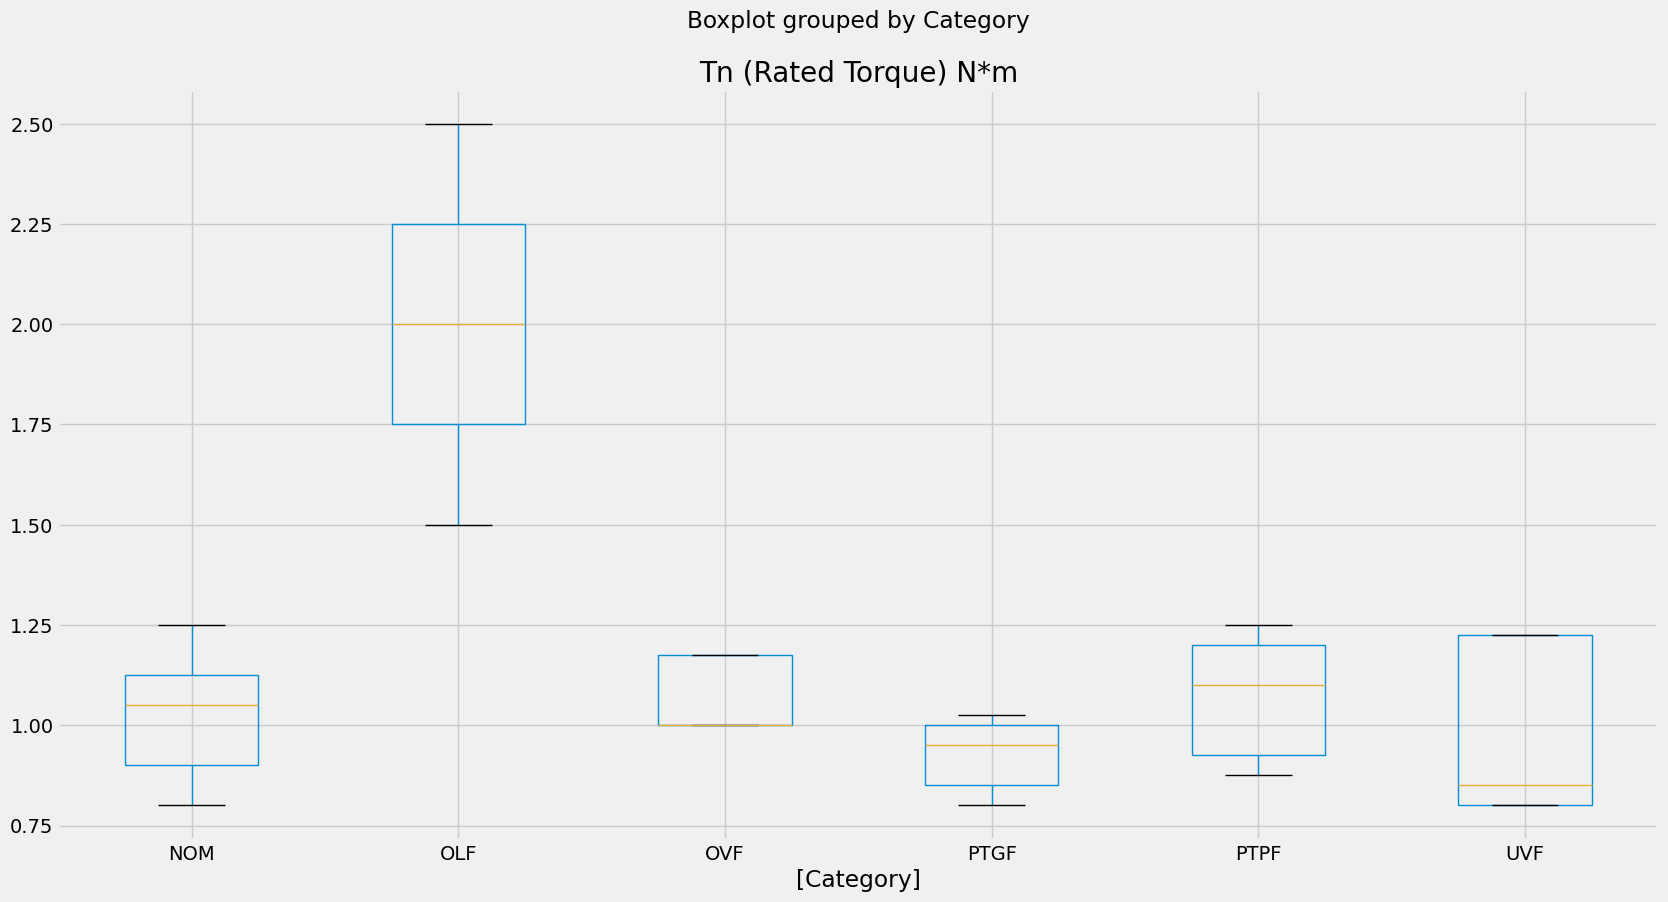

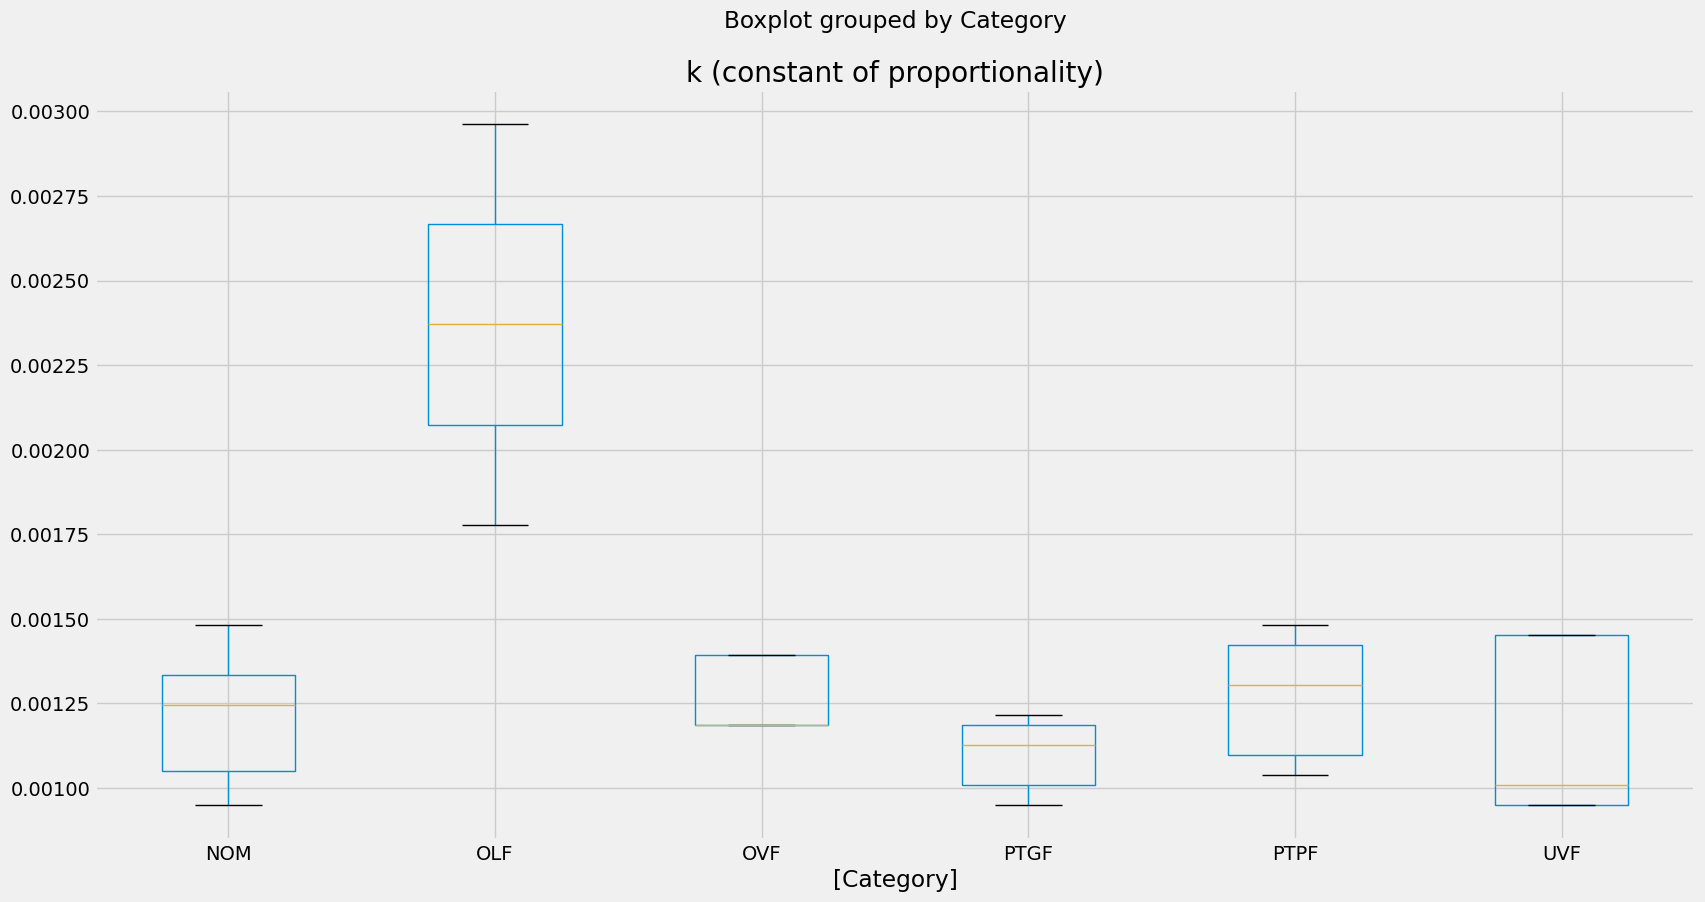

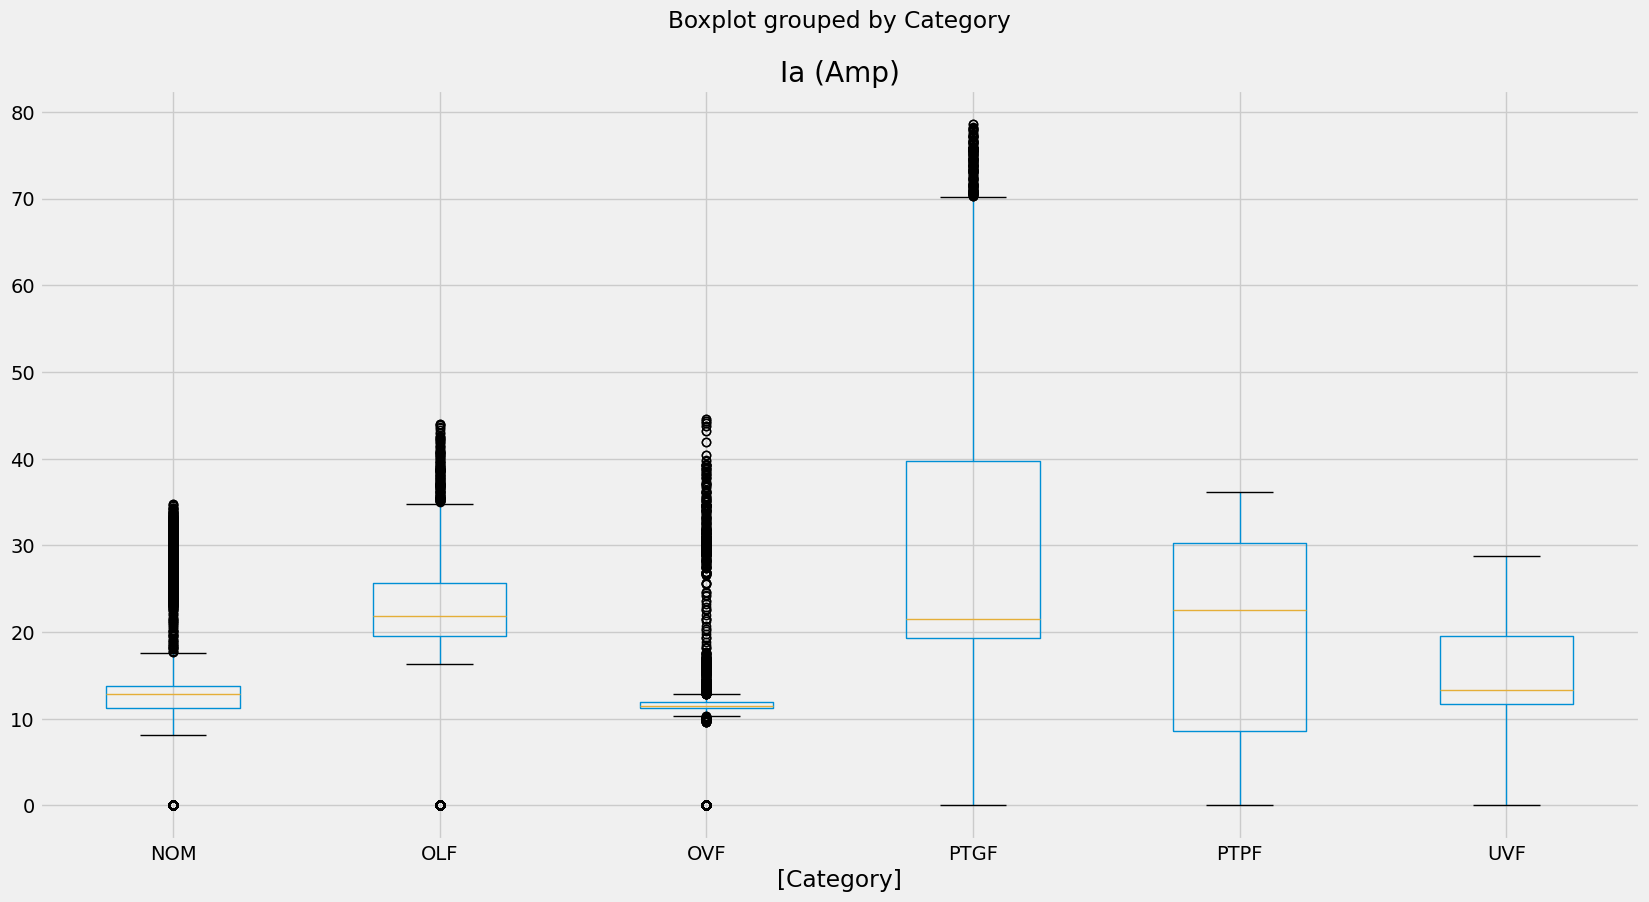

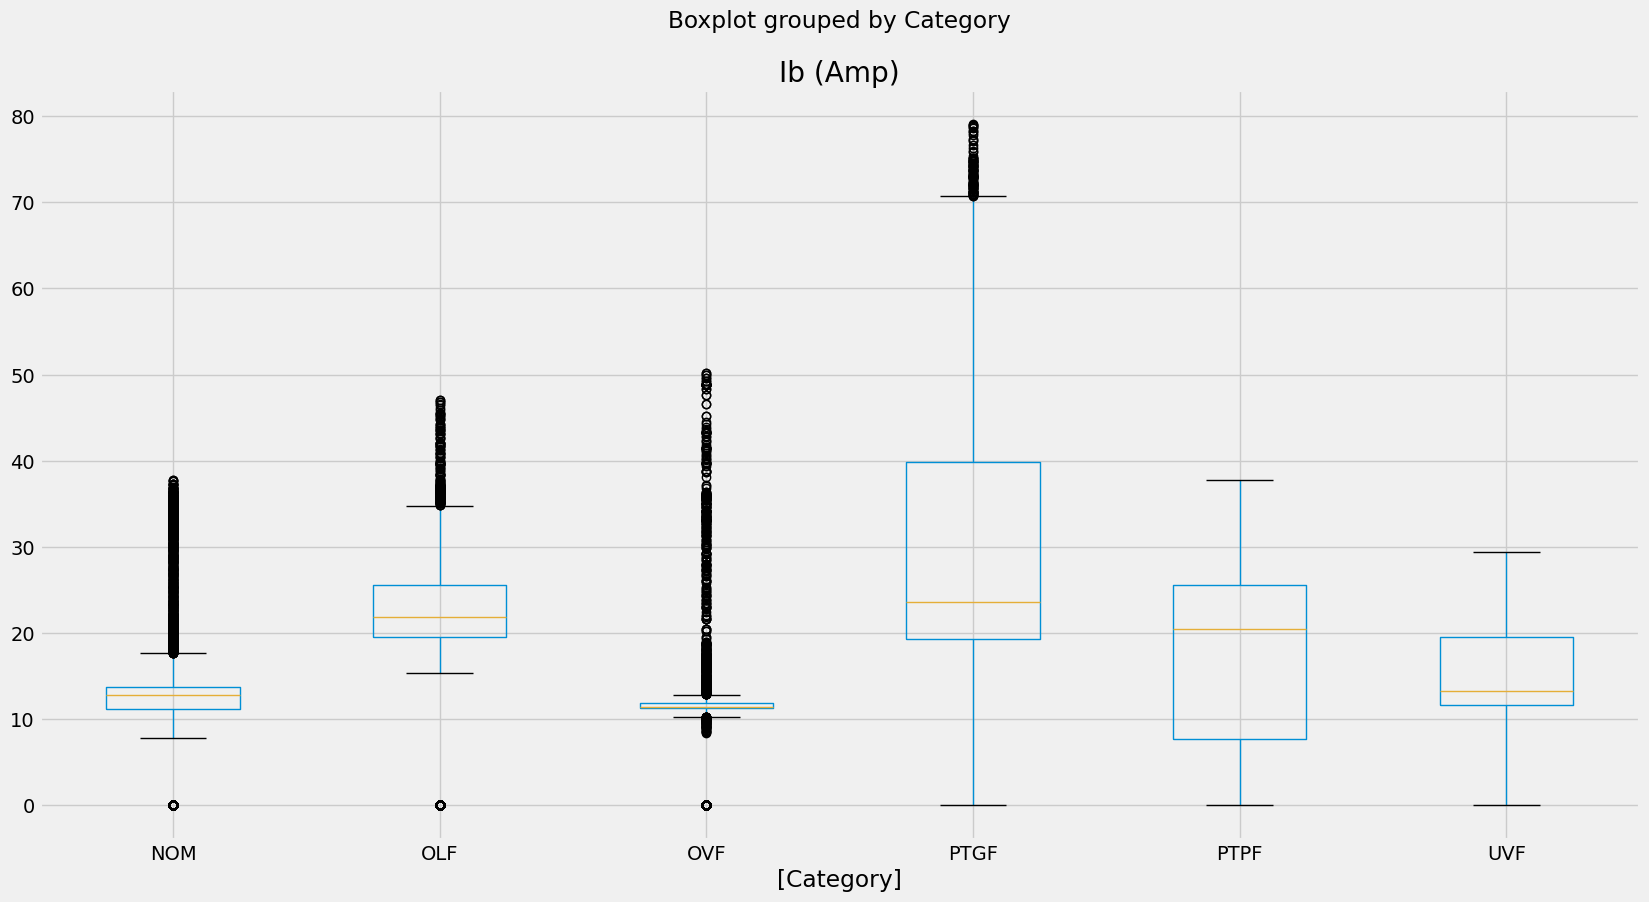

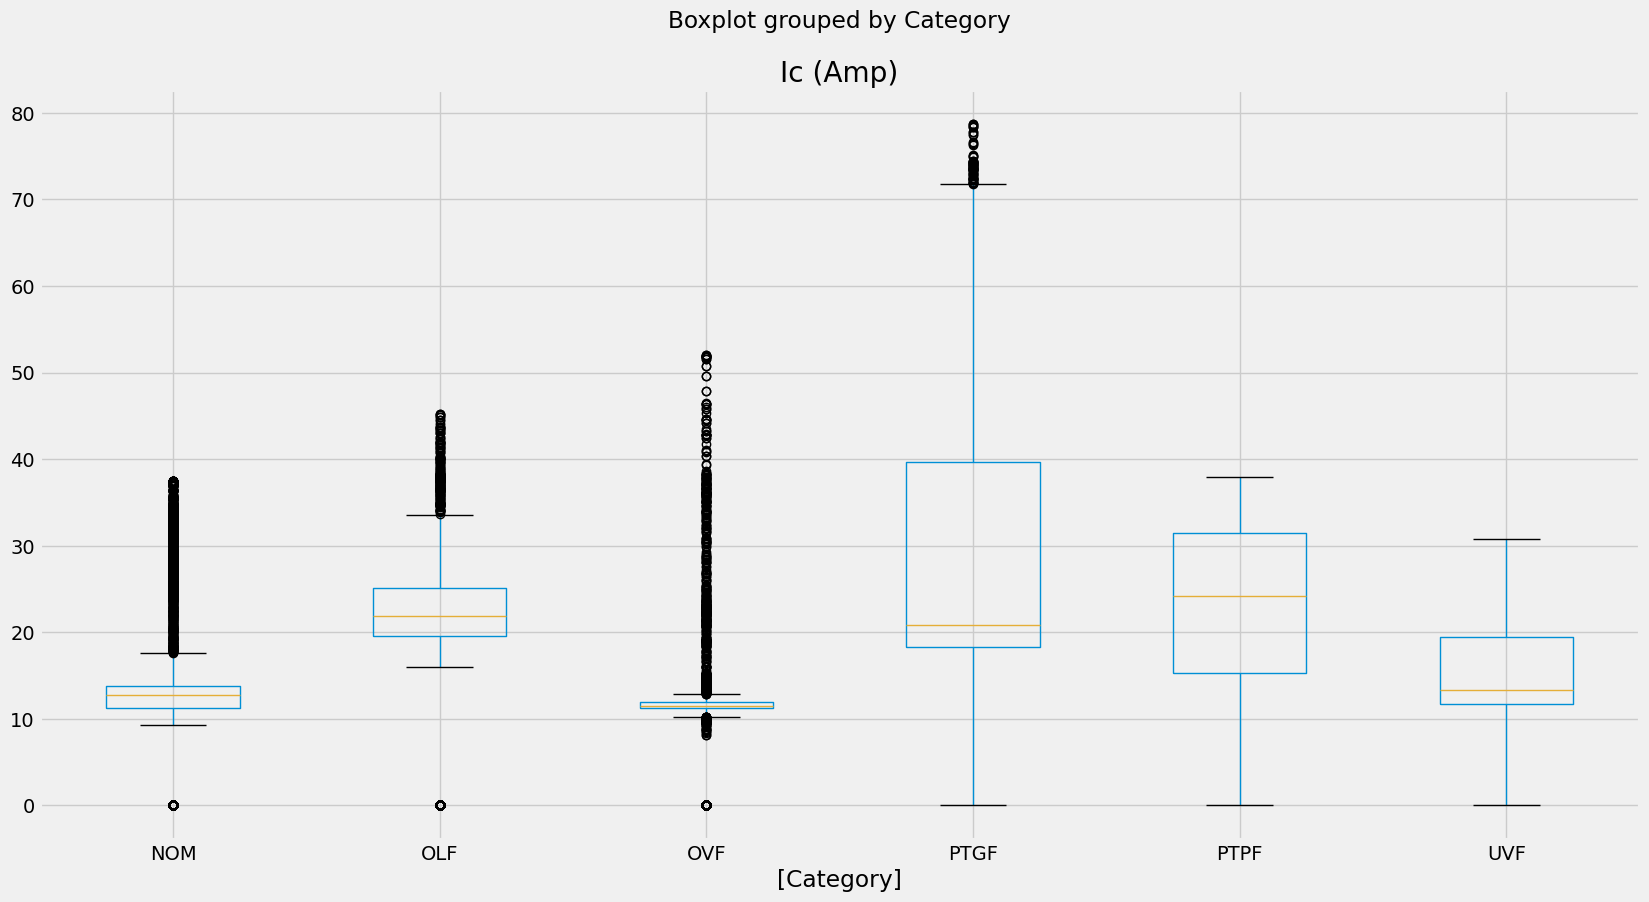

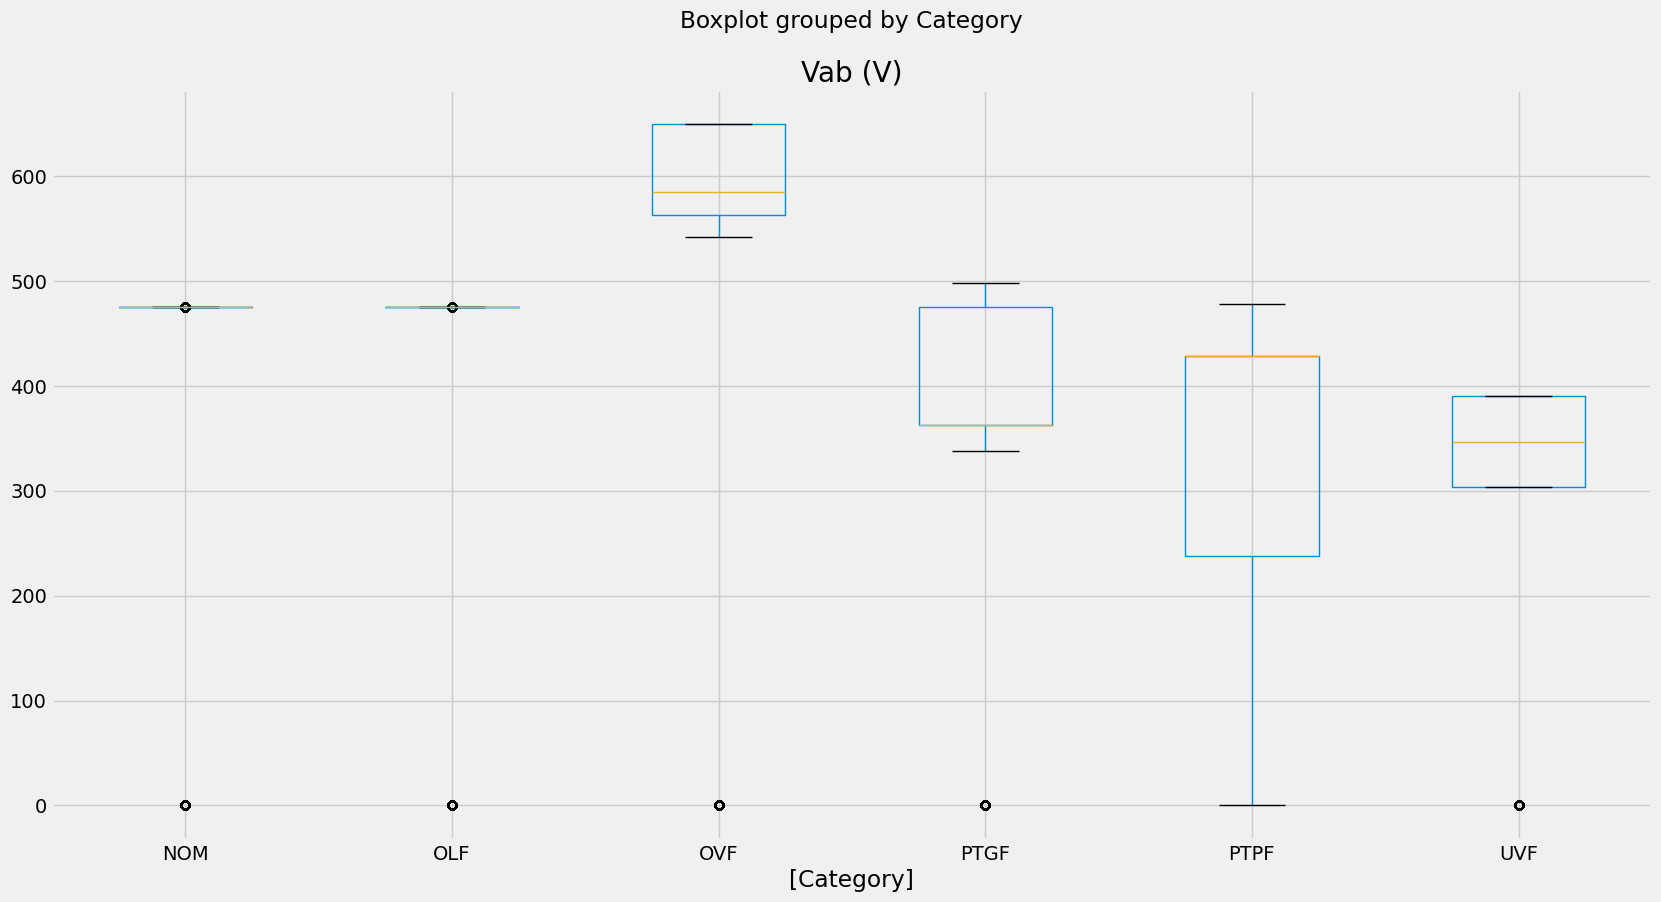

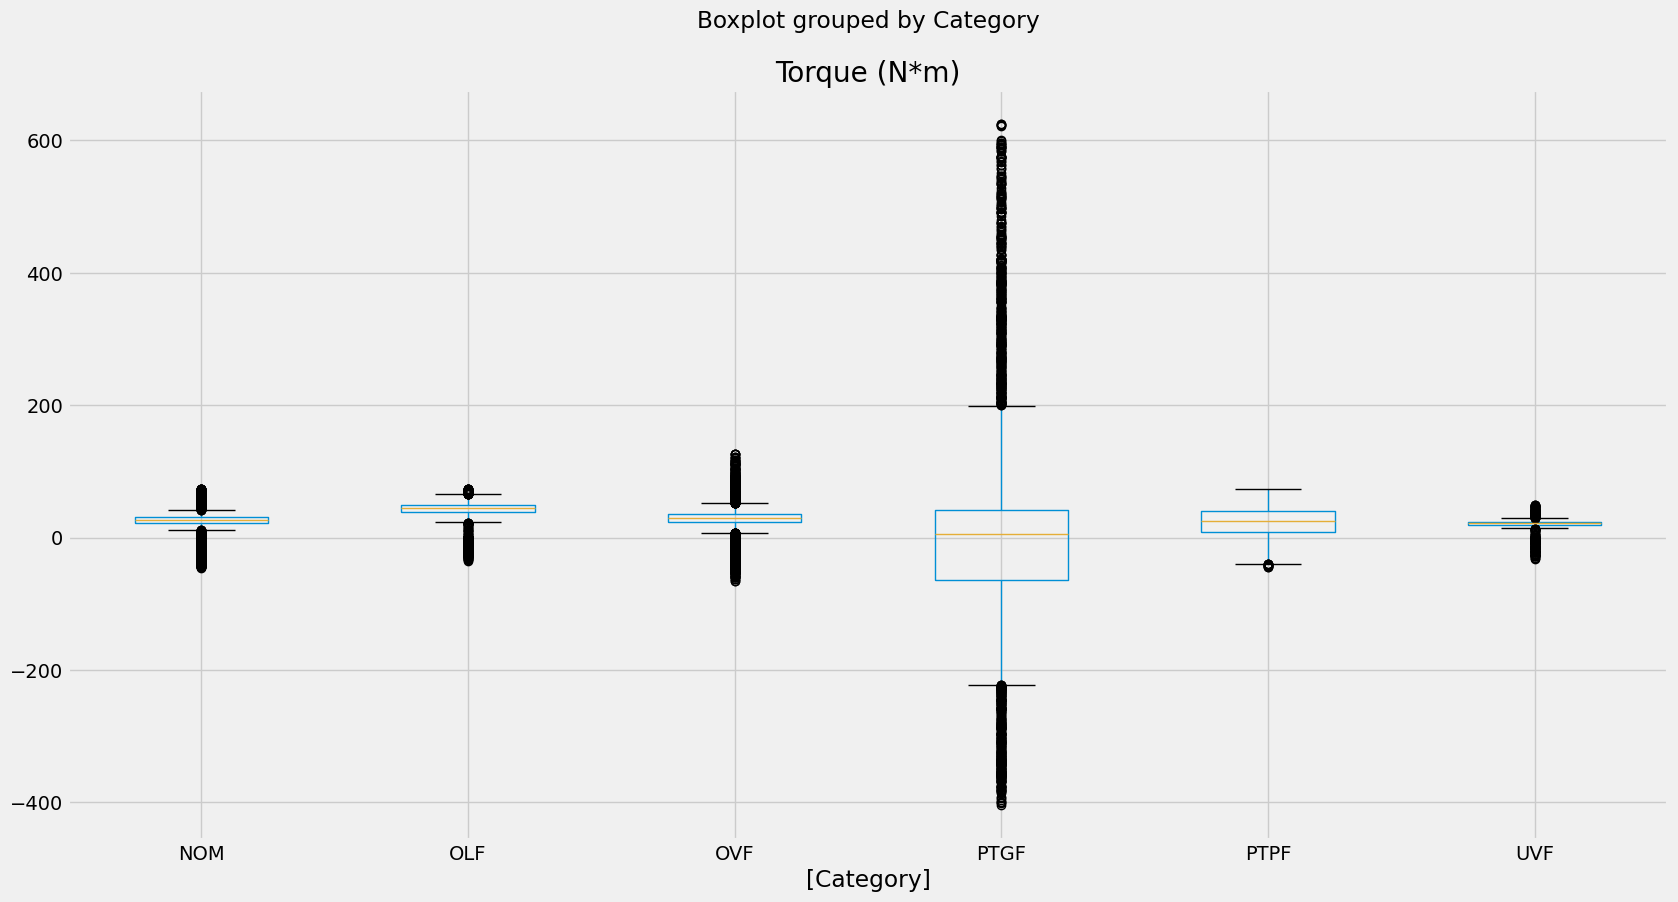

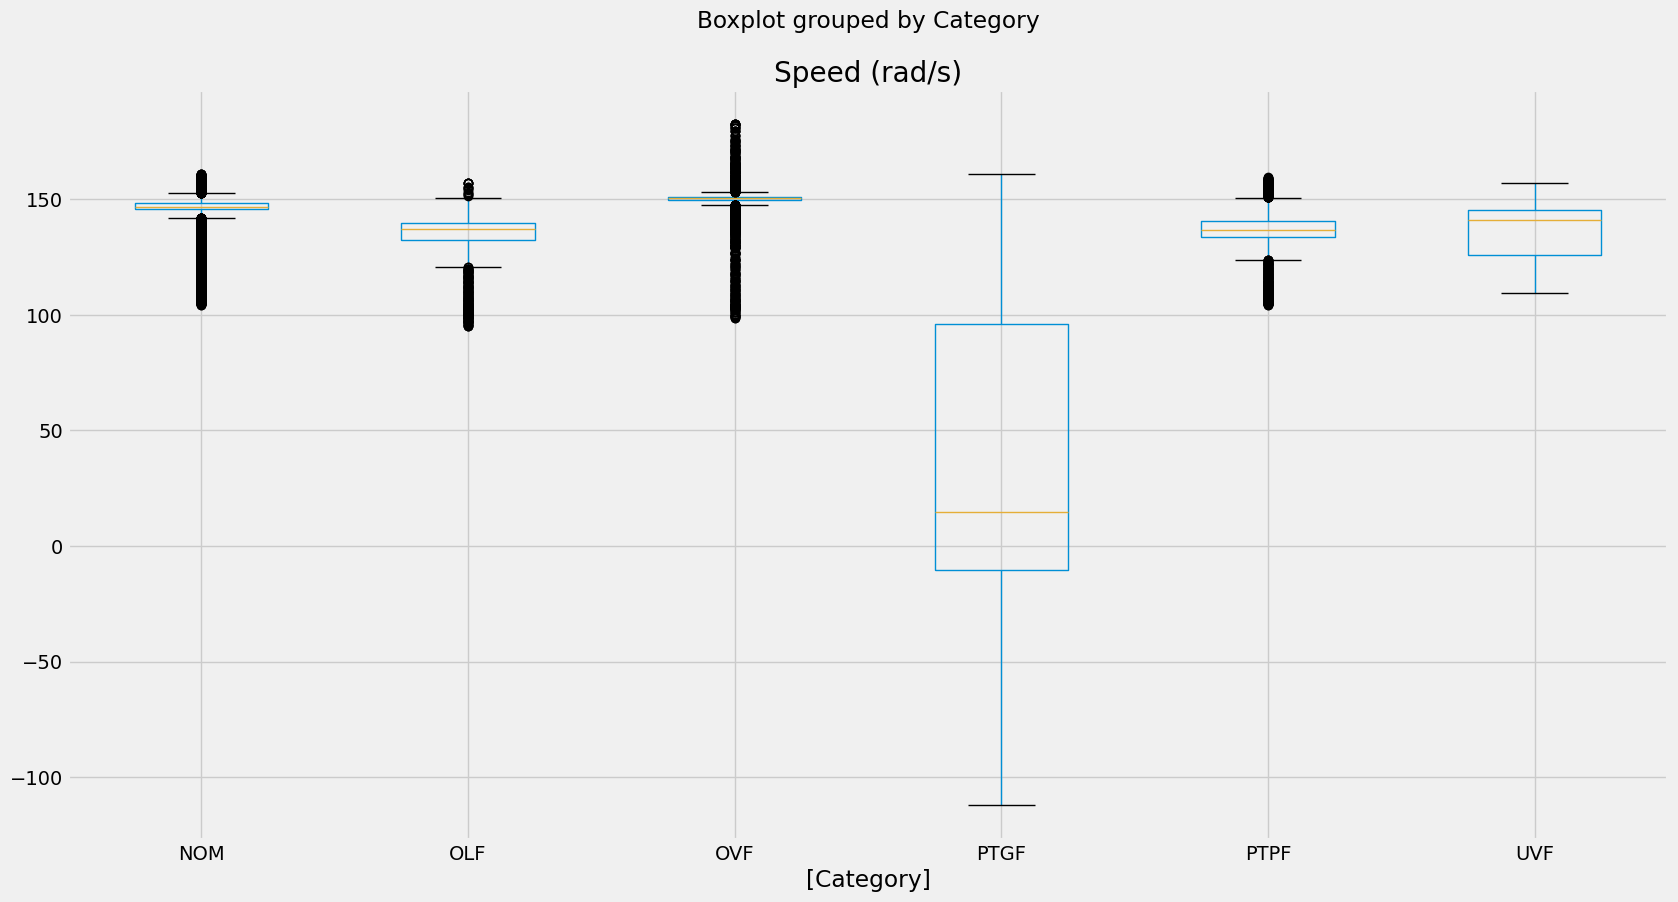

In [ ]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100

#boxplots for each category
for outlier_column in outlier_columns:
    df[[outlier_column] + ["Category"]].boxplot(by="Category", figsize=(20, 10))
plt.show()

In [ ]:
def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """ Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """

    # Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.py

    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["outlier " + col, "no outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

In [ ]:
def mark_outliers_iqr(dataset, col):
    """Function to mark values as outliers using the IQR method.

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )

    return dataset

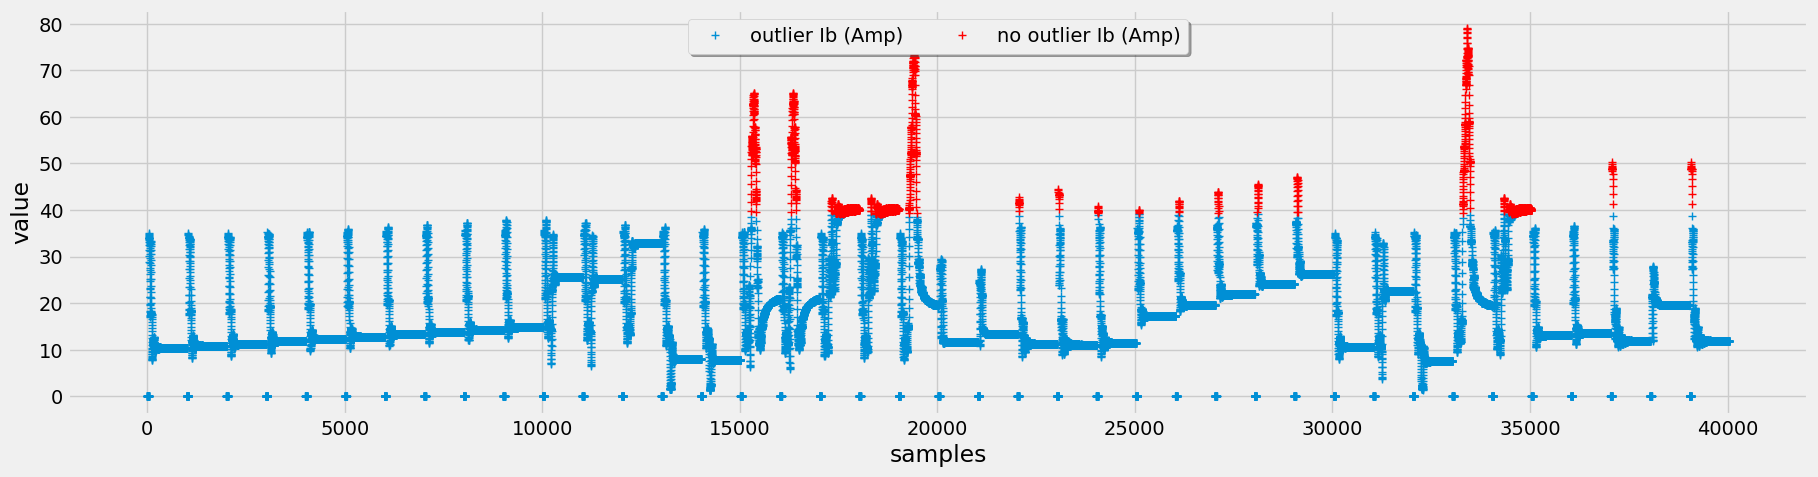

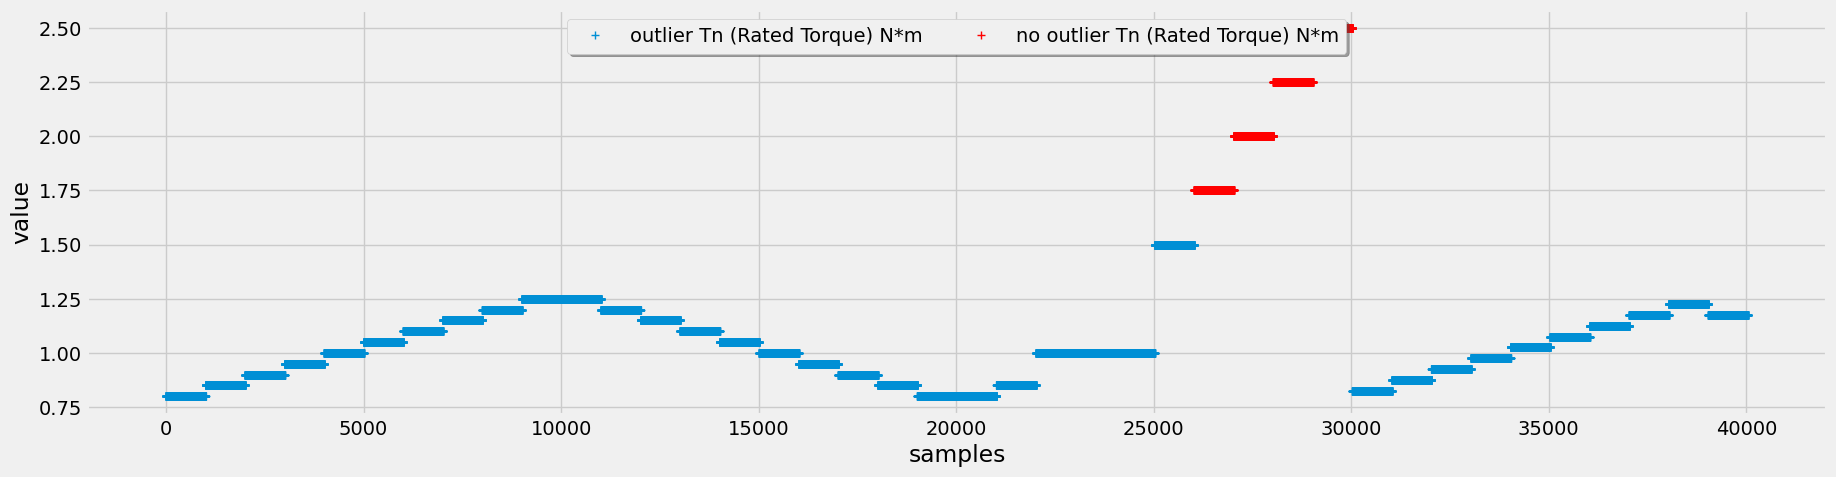

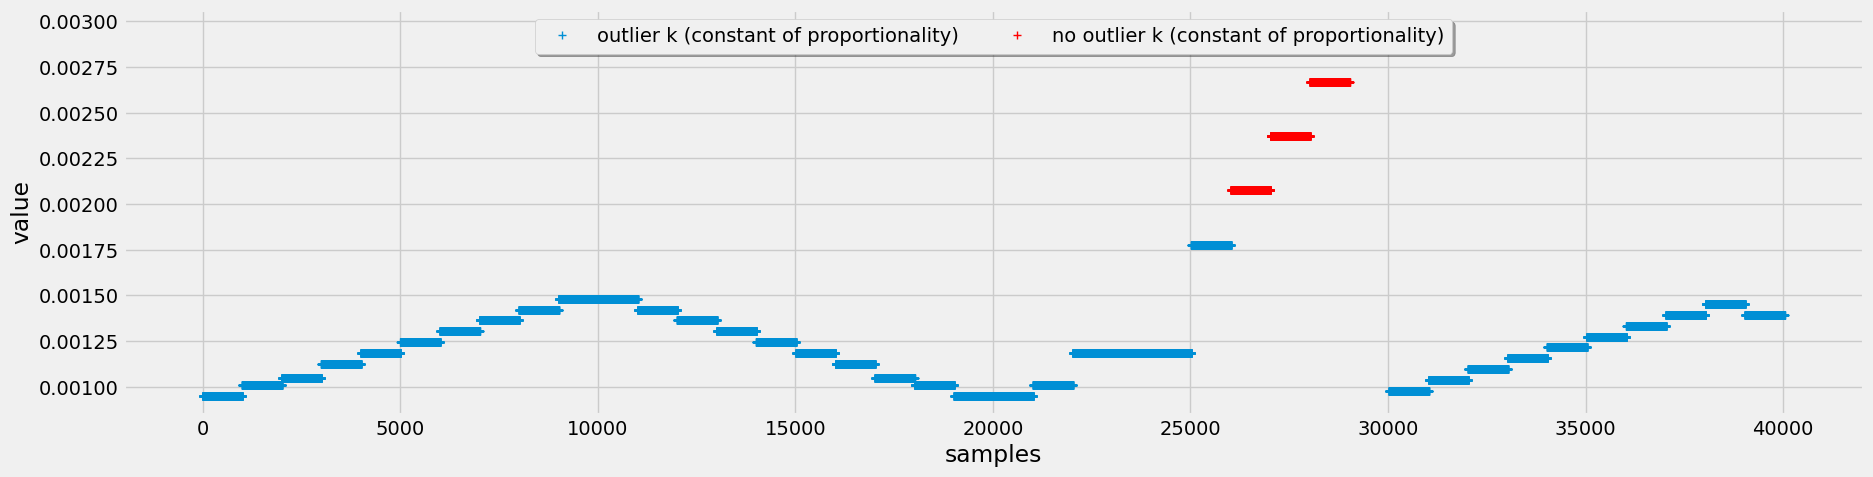

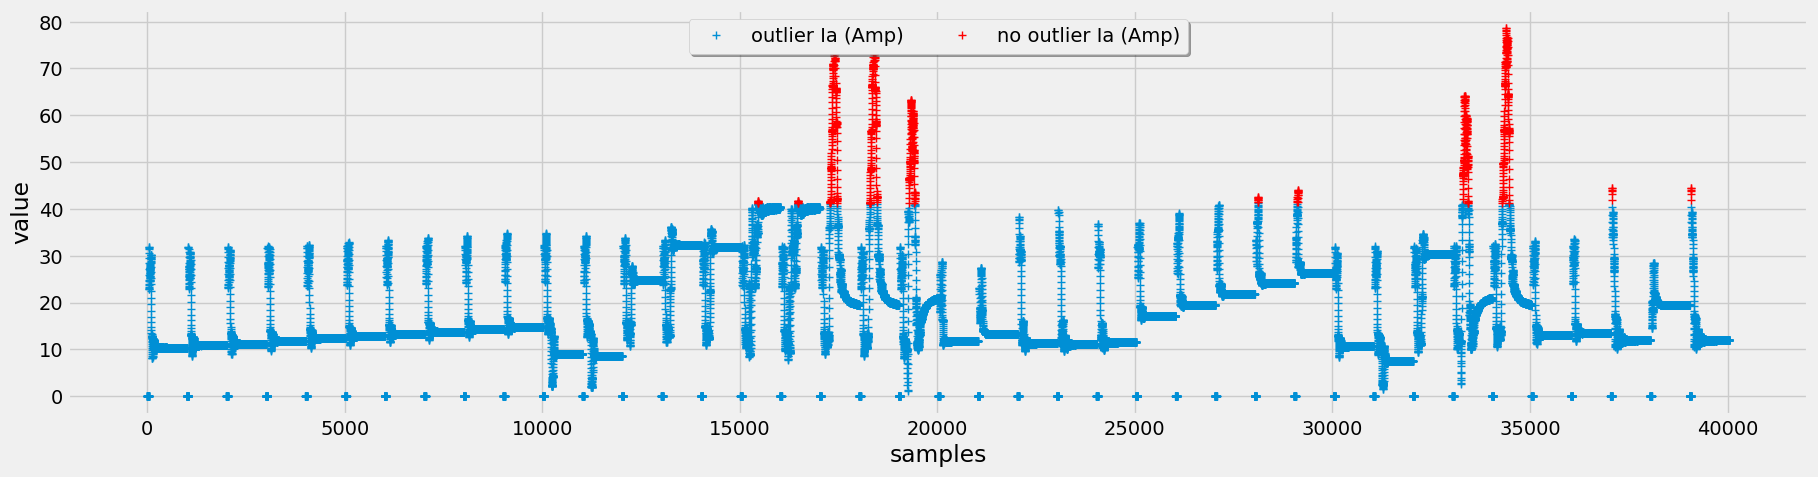

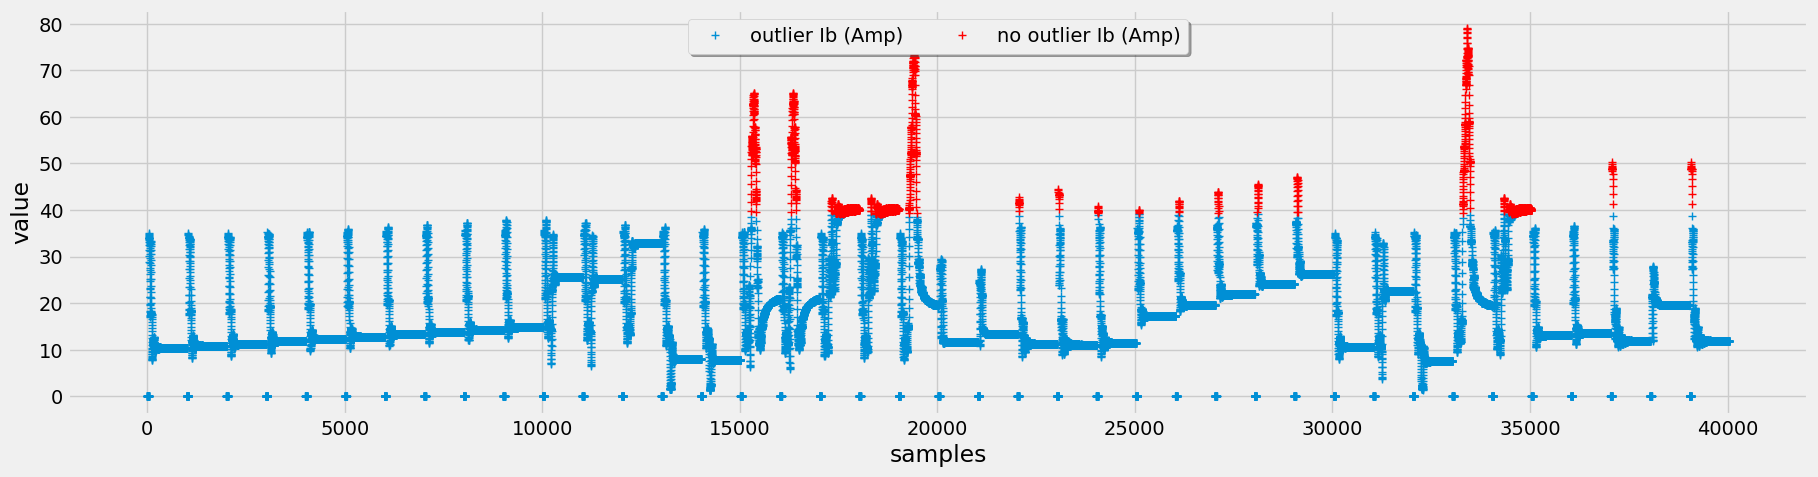

<ipython-input-4-d53dd791573a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[outlier_col] = dataset[outlier_col].astype("bool")


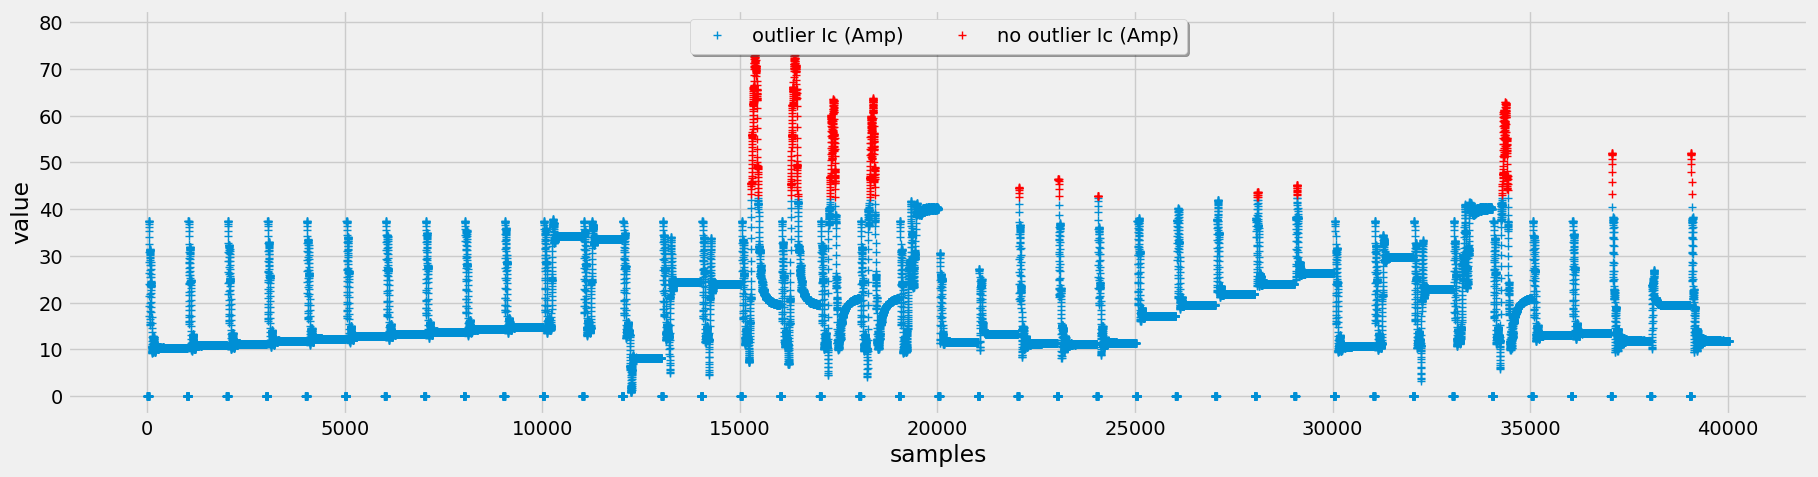

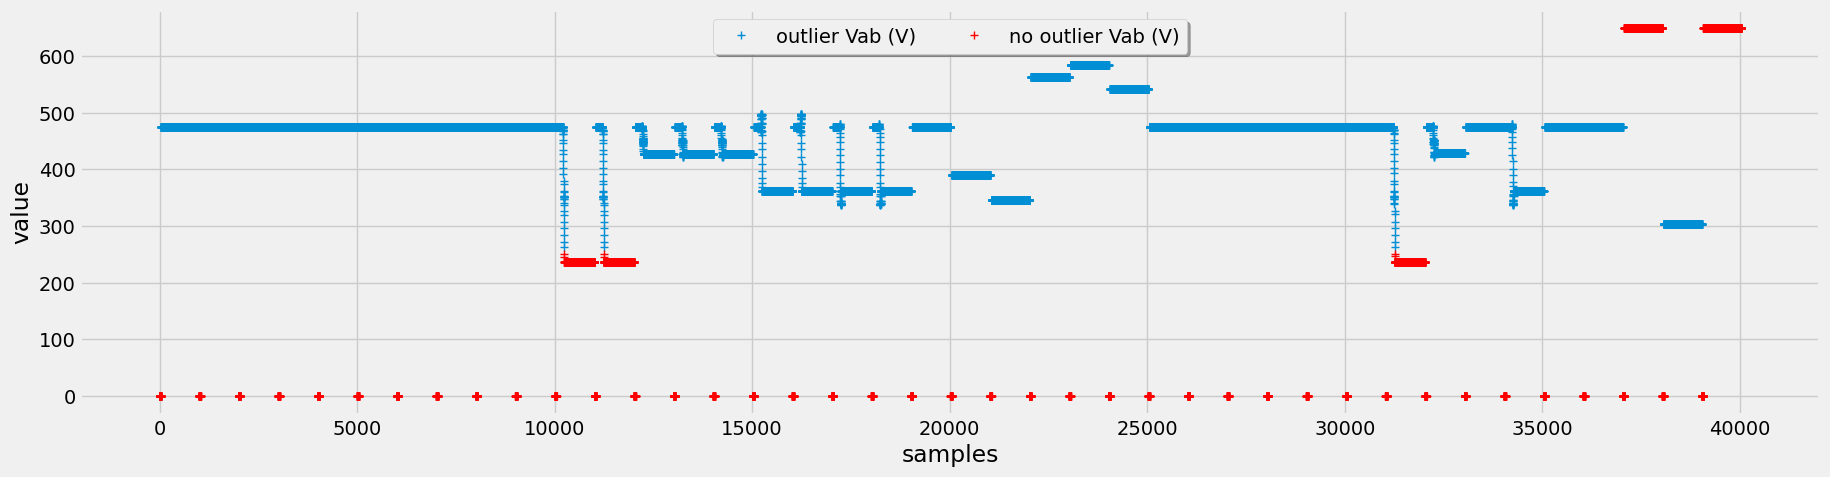

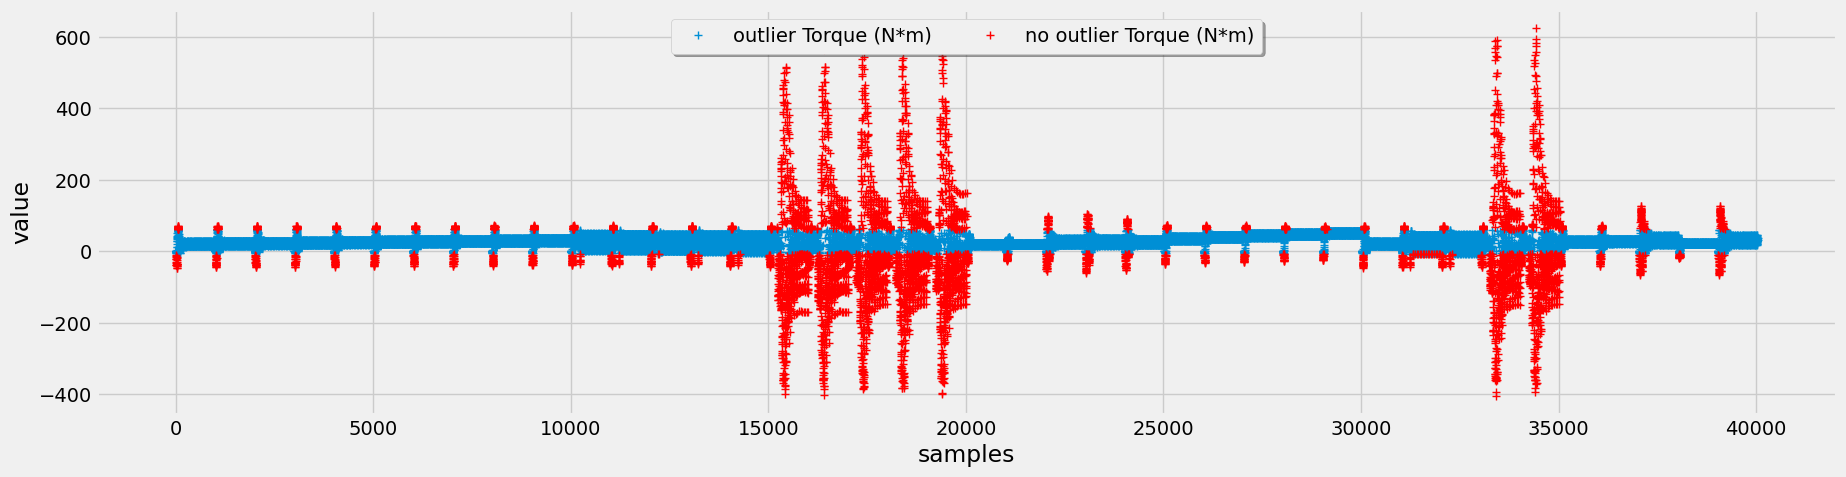

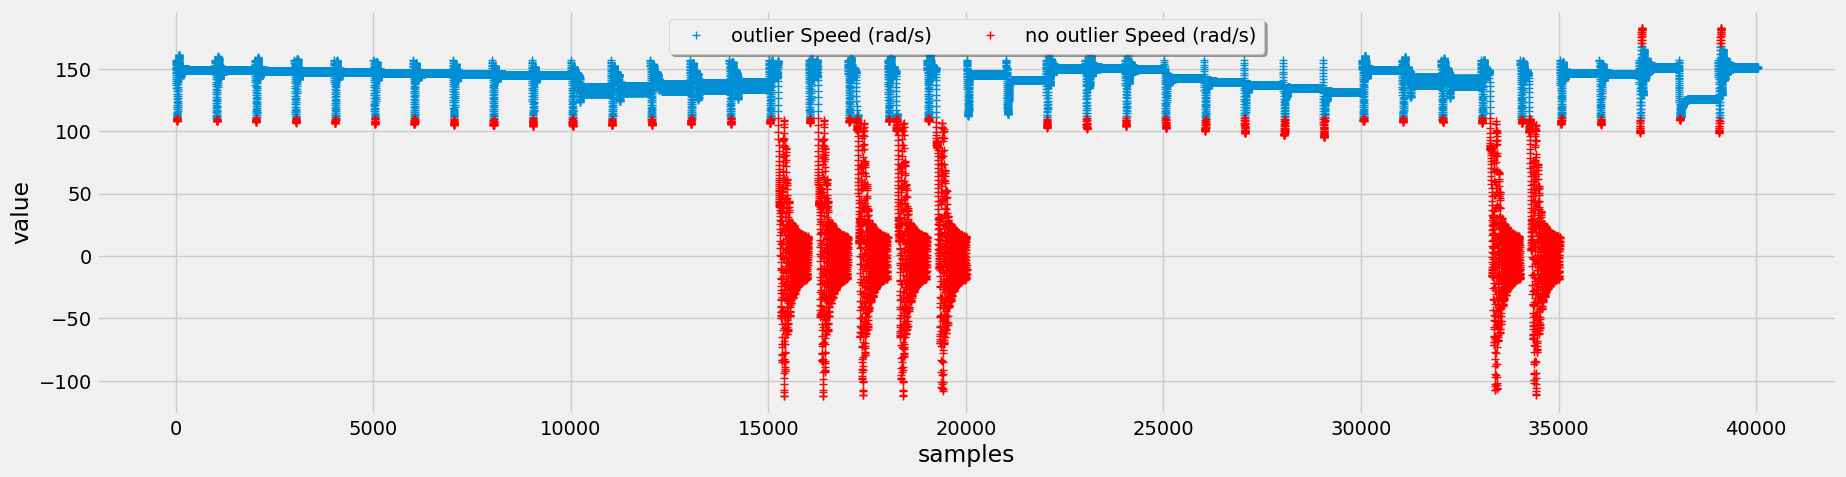

In [ ]:
col = "Ib (Amp)"
dataset = mark_outliers_iqr(df, col)
plot_binary_outliers(dataset=dataset, col=col, outlier_col=col+"_outlier",  reset_index=True)

# Loop over all columns

for col in outlier_columns:
    dataset = mark_outliers_iqr(df, col)
    plot_binary_outliers(dataset=dataset, col=col, outlier_col=col+"_outlier",  reset_index=True)

array([[<Axes: title={'center': 'NOM'}>, <Axes: title={'center': 'OLF'}>,
        <Axes: title={'center': 'OVF'}>],
       [<Axes: title={'center': 'PTGF'}>,
        <Axes: title={'center': 'PTPF'}>,
        <Axes: title={'center': 'UVF'}>],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

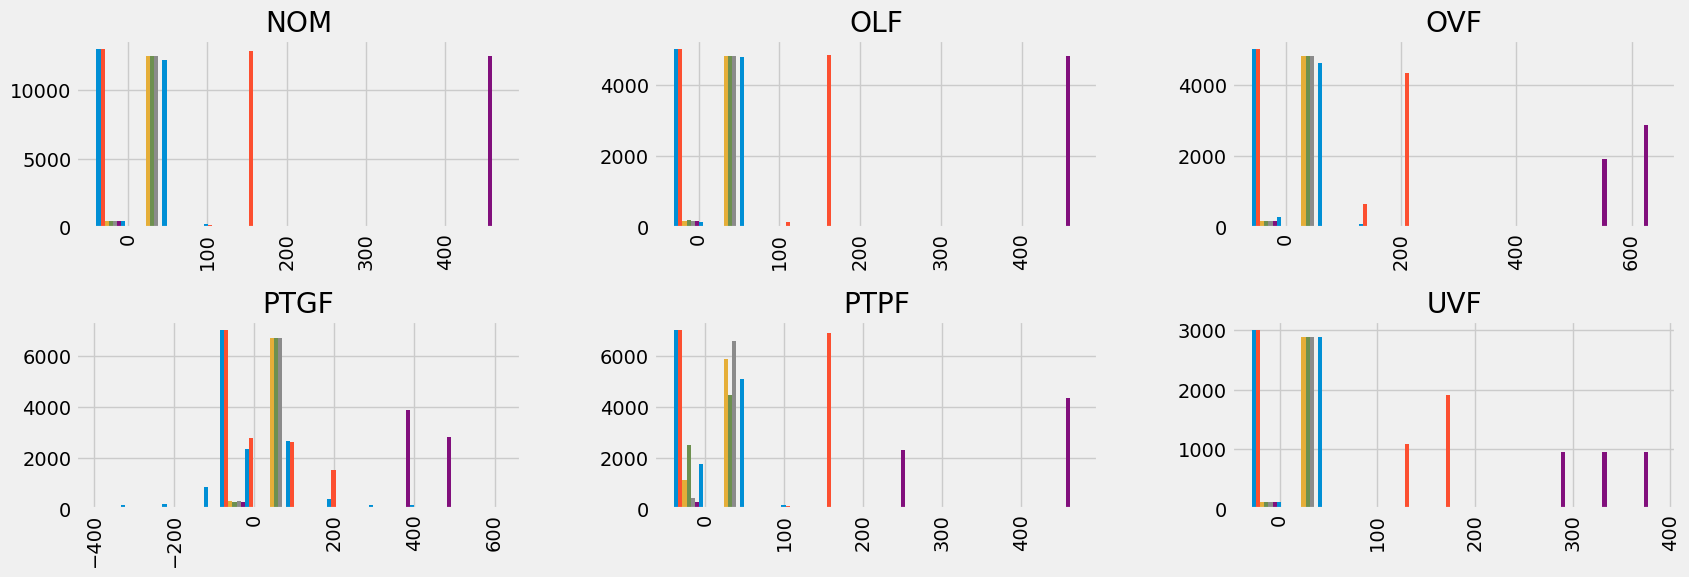

In [ ]:
df[outlier_columns + ["Category"]].hist(by="Category", figsize=(20, 10), layout=(3, 3))

In [ ]:
def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.
    
    Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption 
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()
    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):
        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high.iloc[i]) - scipy.special.erf(low.iloc[i]))
        )
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    dataset[col + "_outlier"] = mask
    return dataset

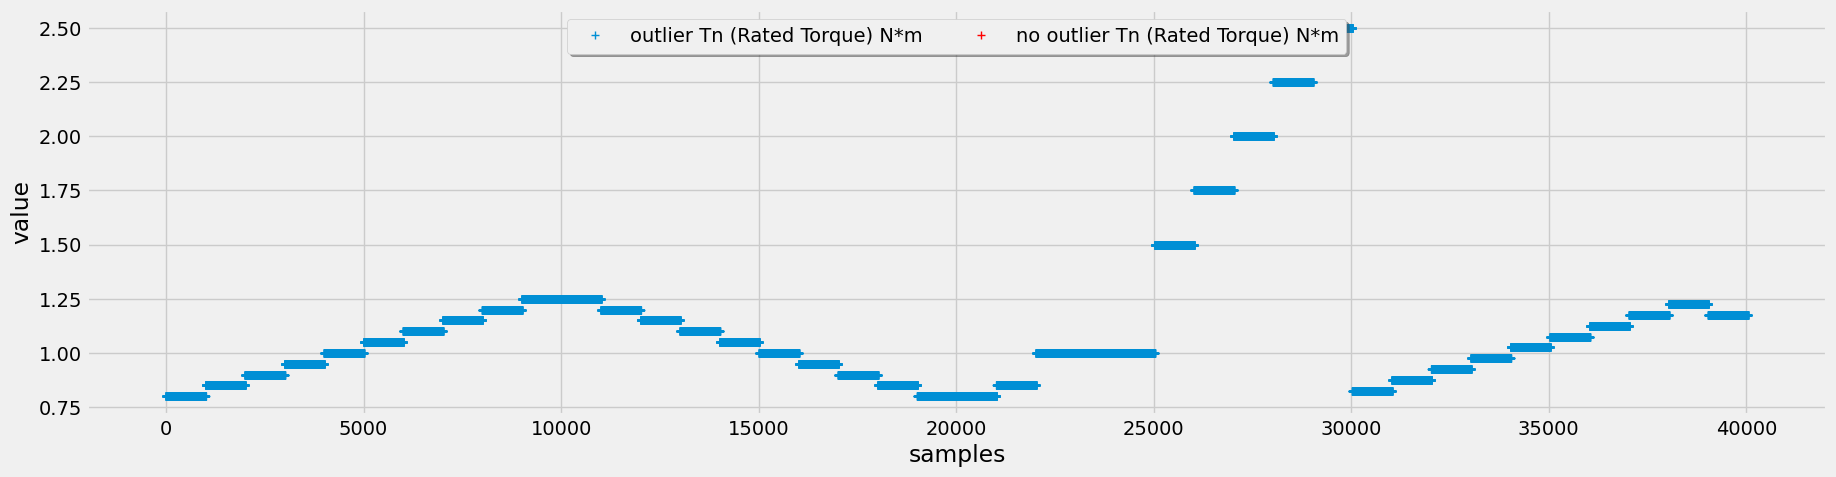

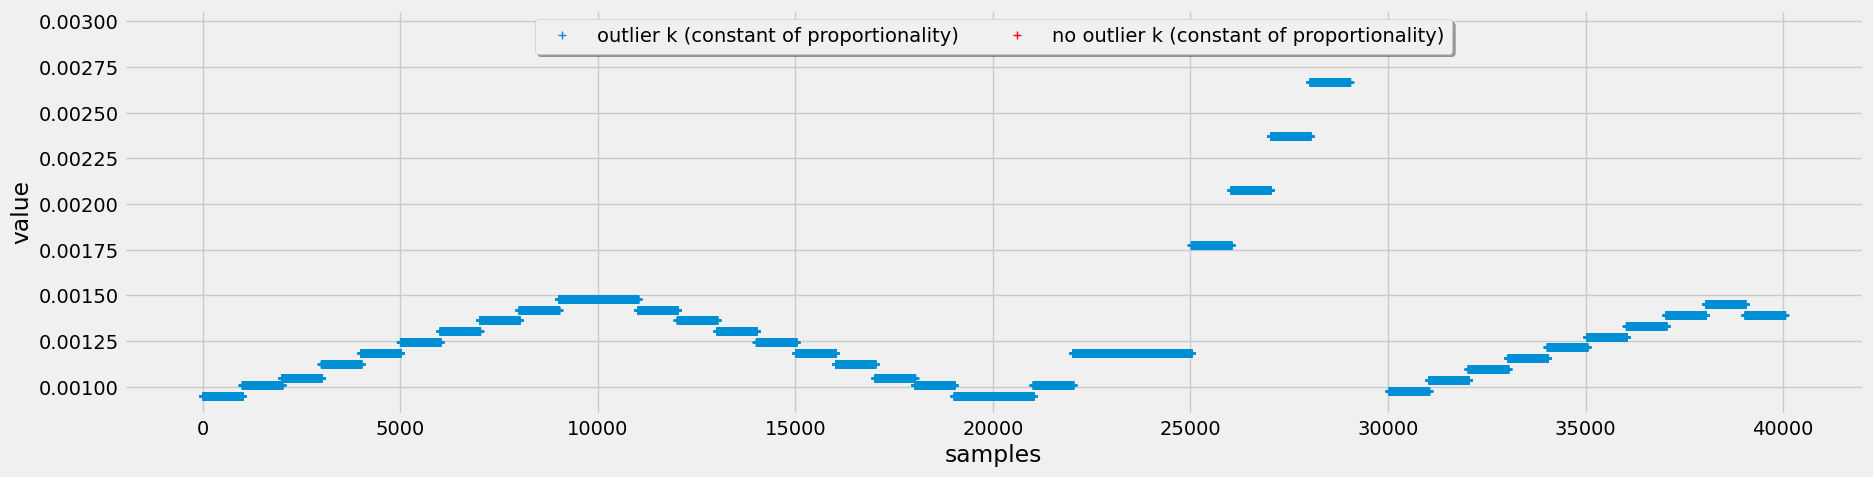

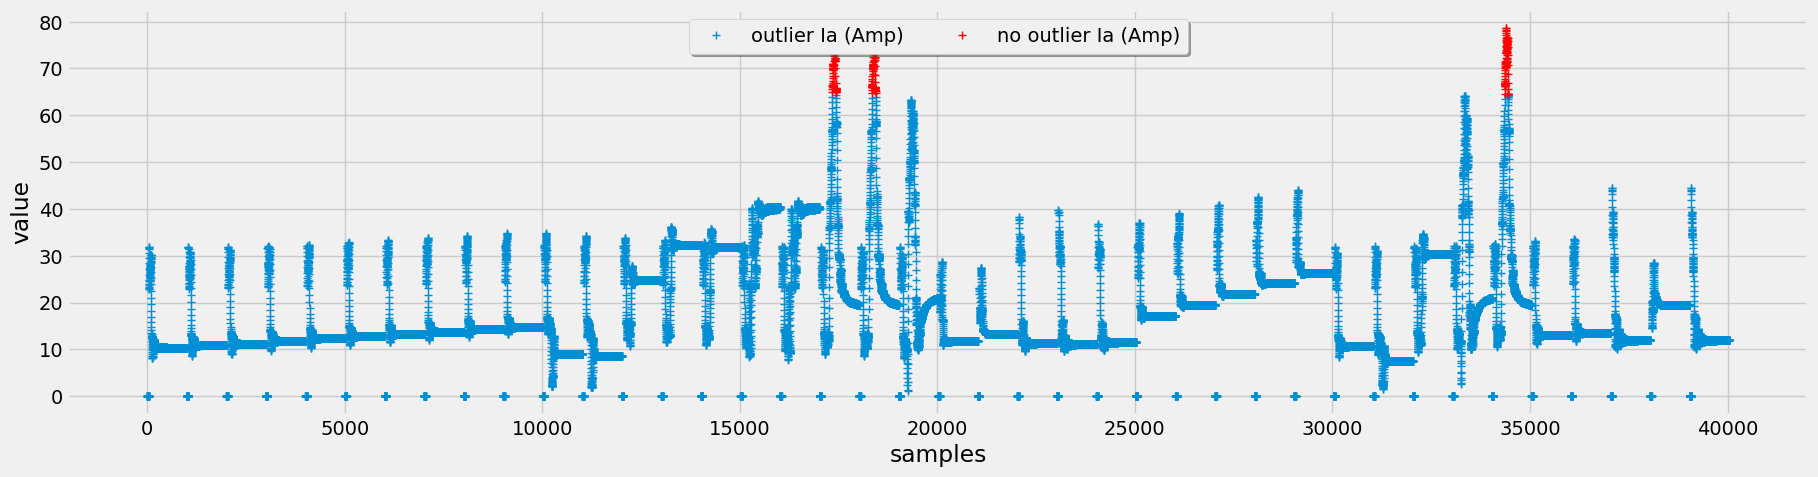

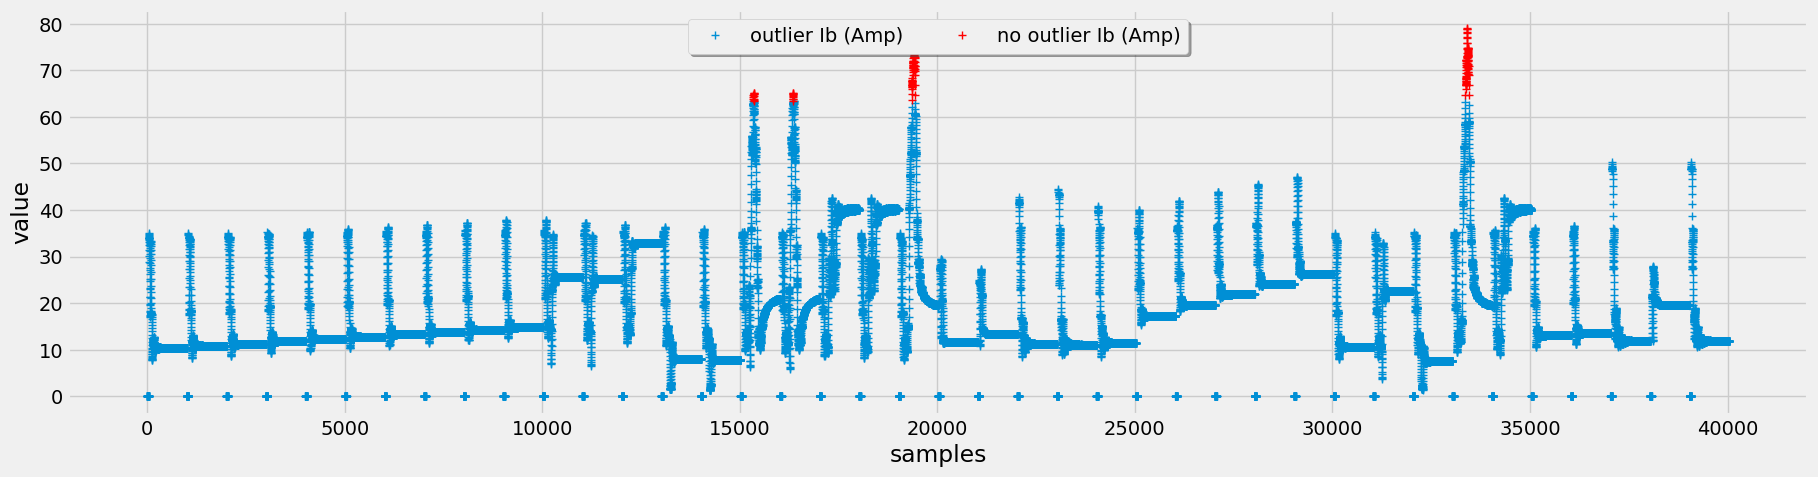

<ipython-input-4-d53dd791573a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[outlier_col] = dataset[outlier_col].astype("bool")


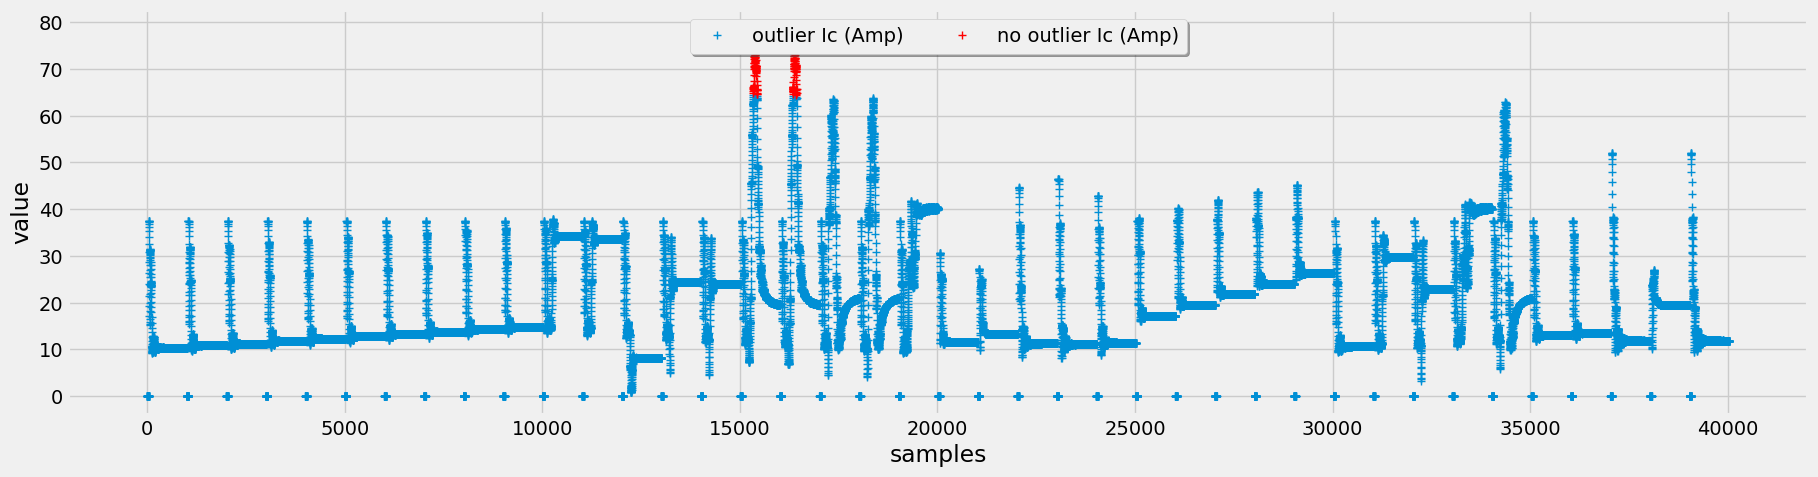

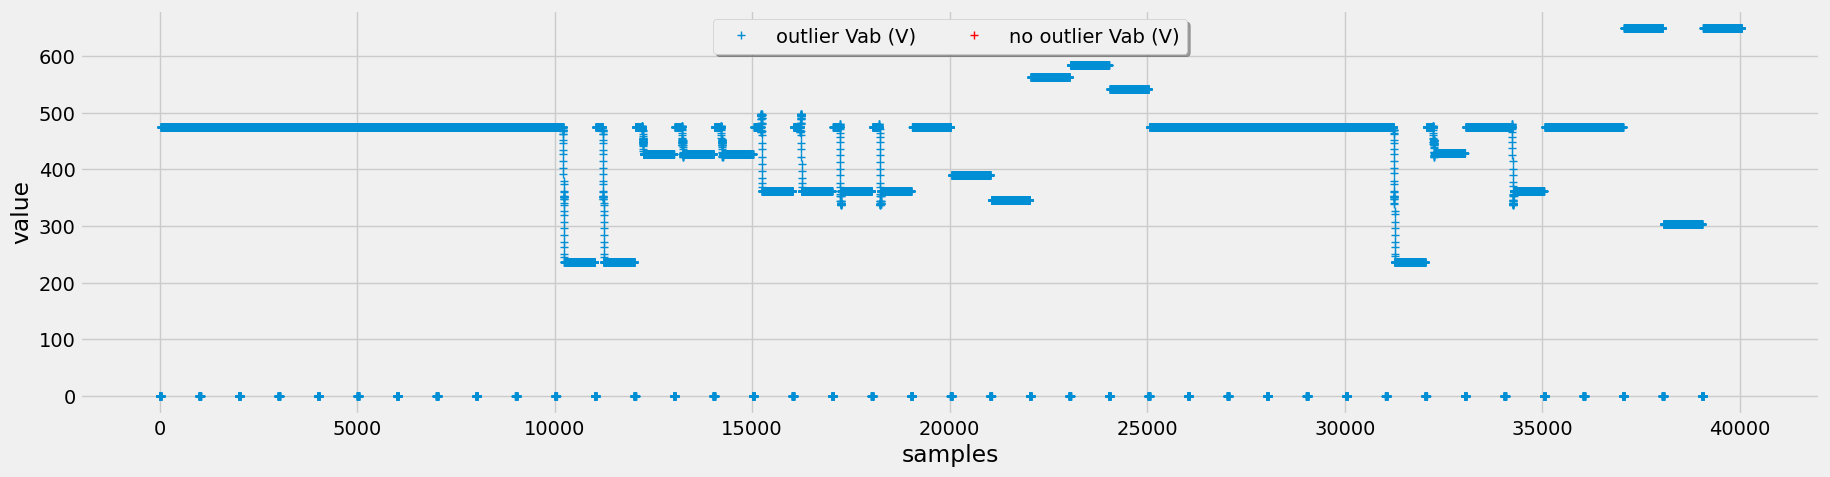

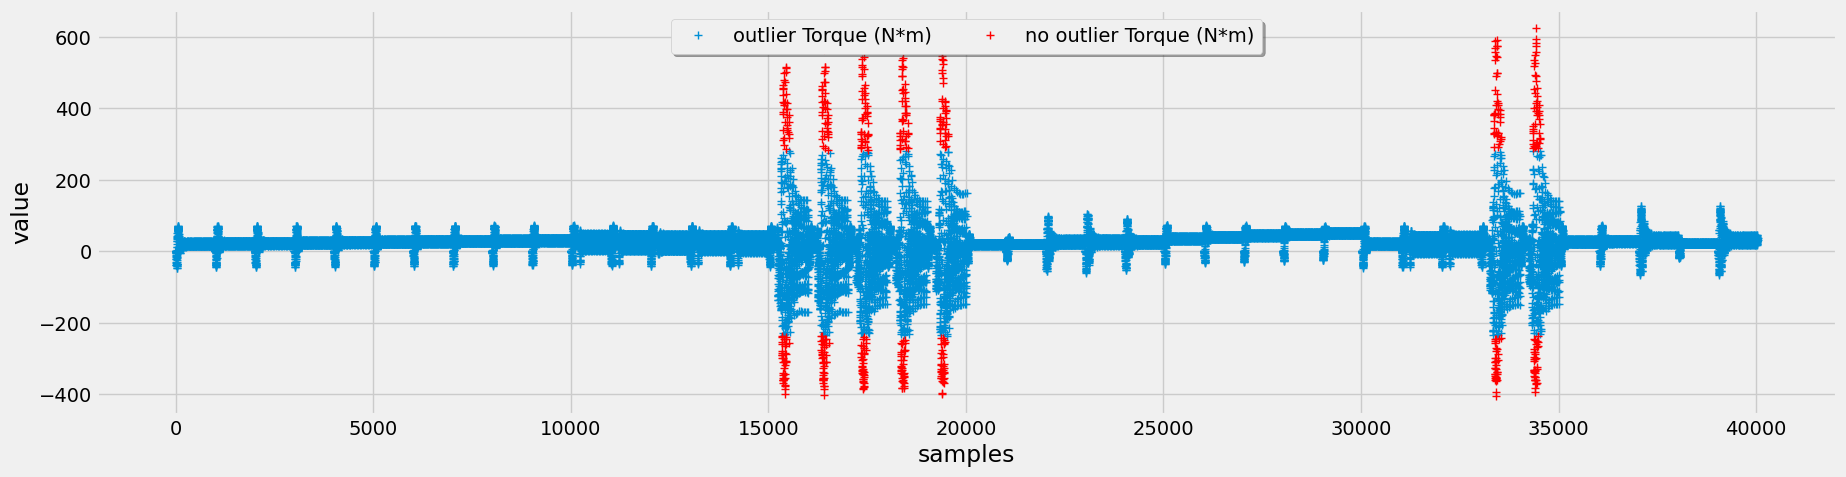

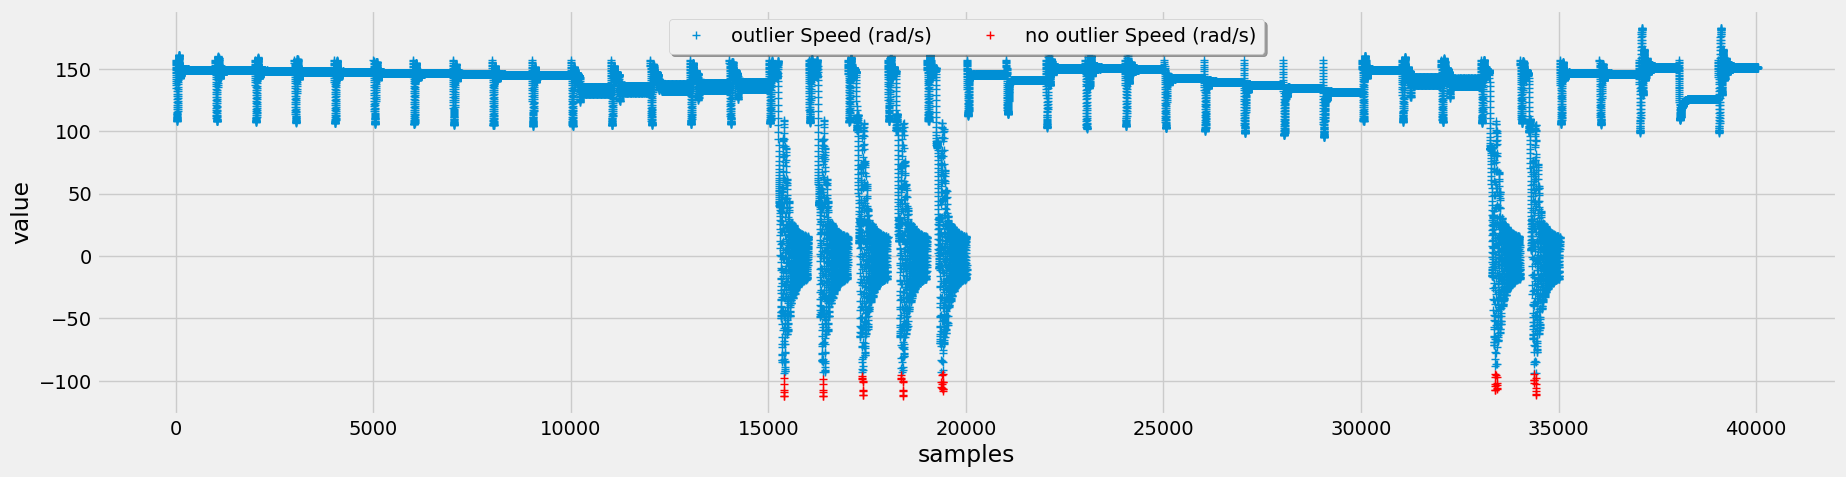

In [ ]:
for col in outlier_columns:
    dataset = mark_outliers_chauvenet(df, col)
    plot_binary_outliers(dataset=dataset, col=col, outlier_col=col+"_outlier",  reset_index=True)

In [ ]:
def mark_outliers_lof(dataset, columns, n=20):
    """Mark values as outliers using LOF

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        n (int, optional): n_neighbors. Defaults to 20.
    
    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """
    
    dataset = dataset.copy()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1
    return dataset, outliers, X_scores

In [ ]:
df = df.dropna()

In [ ]:
dataset, outliers, X_scores = mark_outliers_lof(df, outlier_columns)

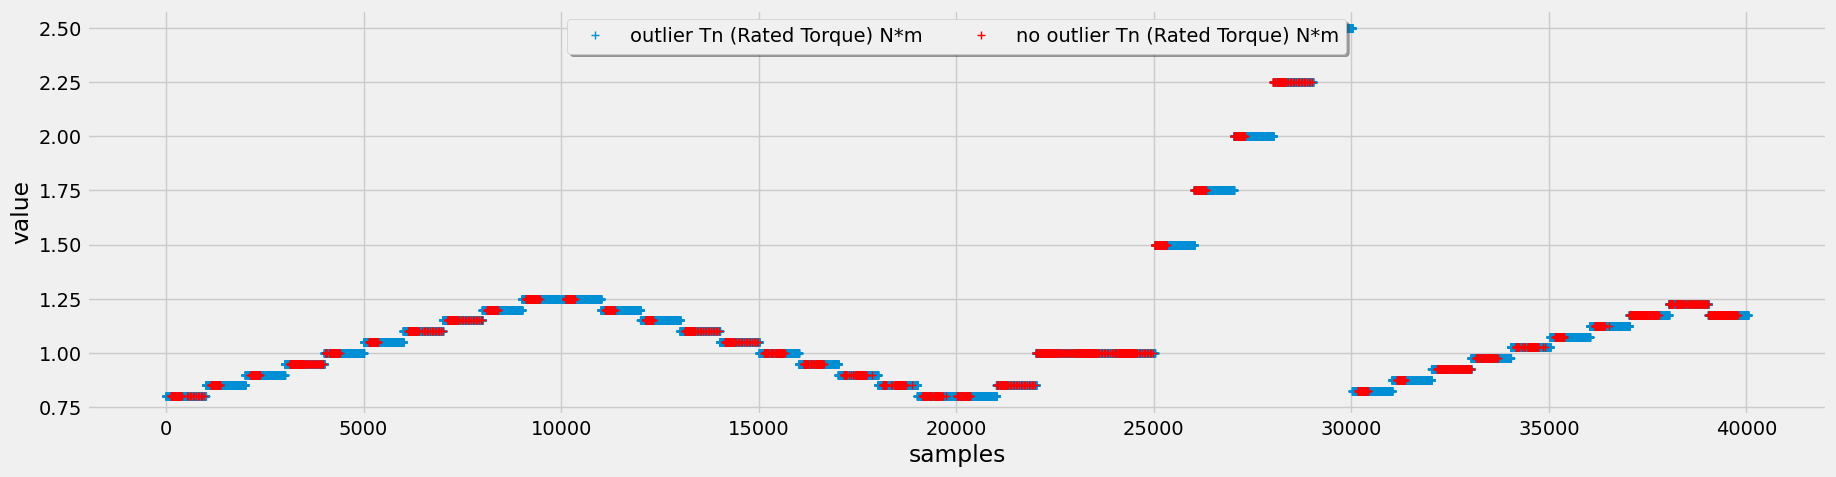

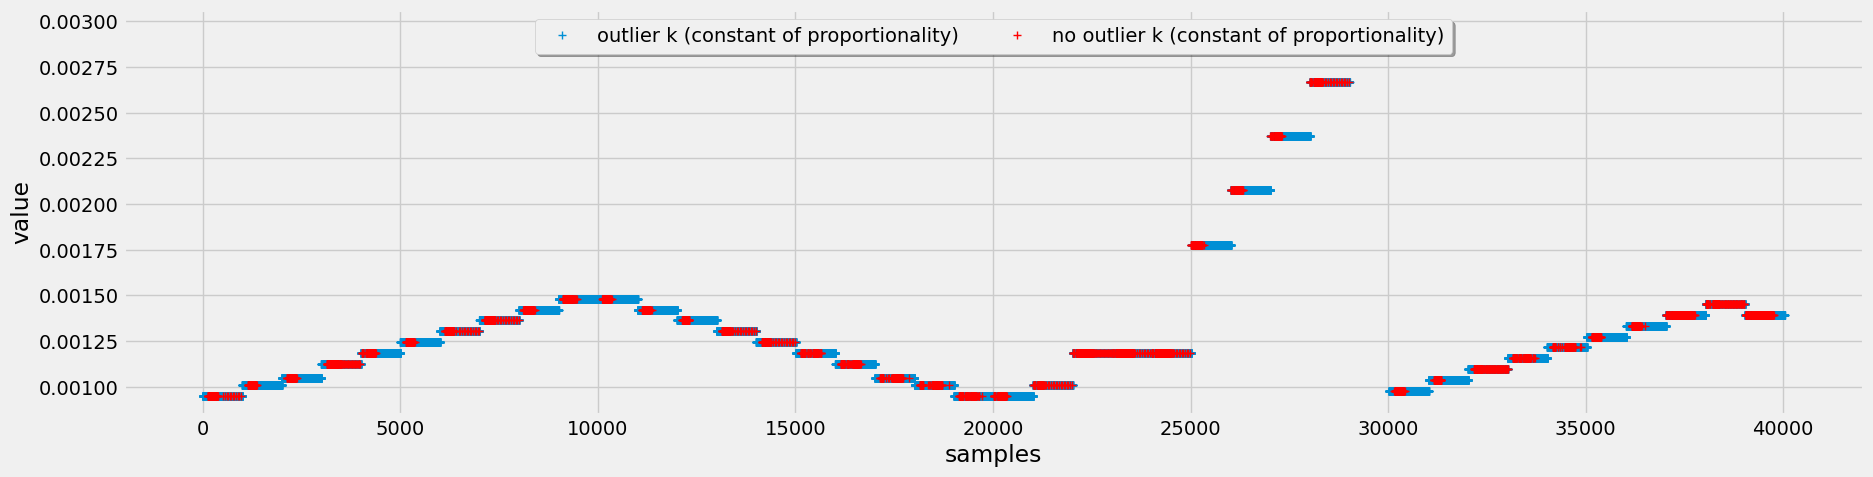

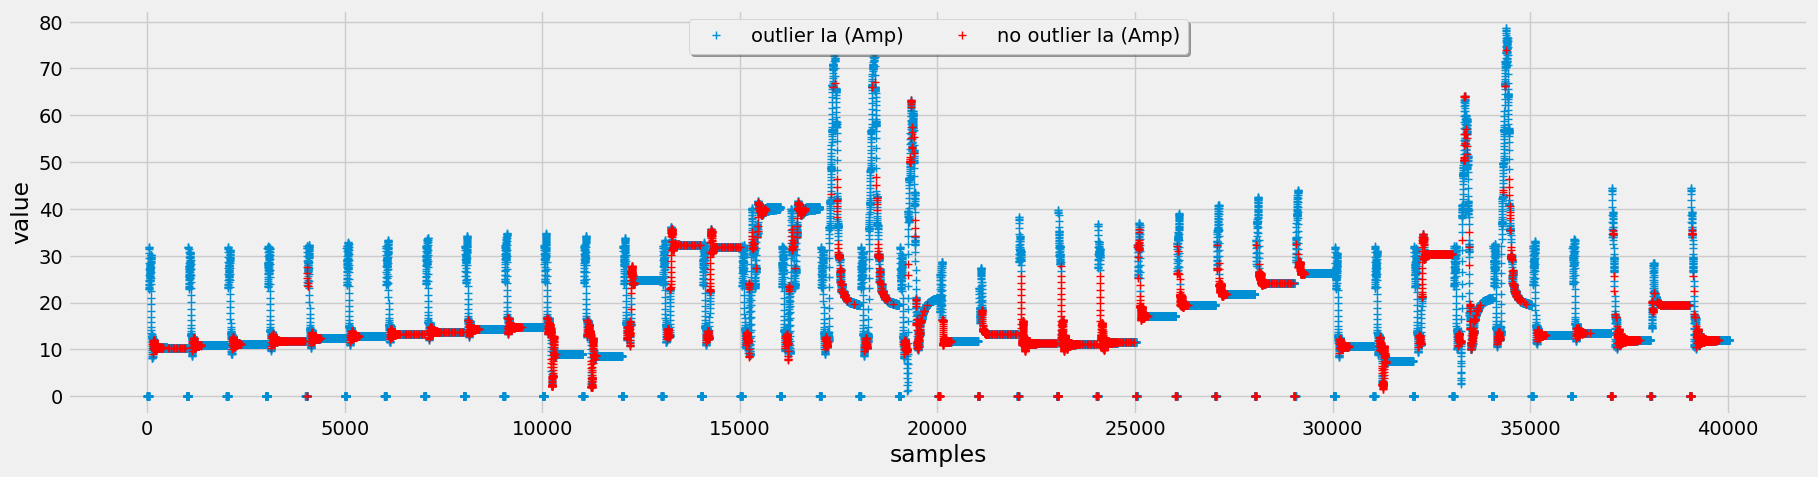

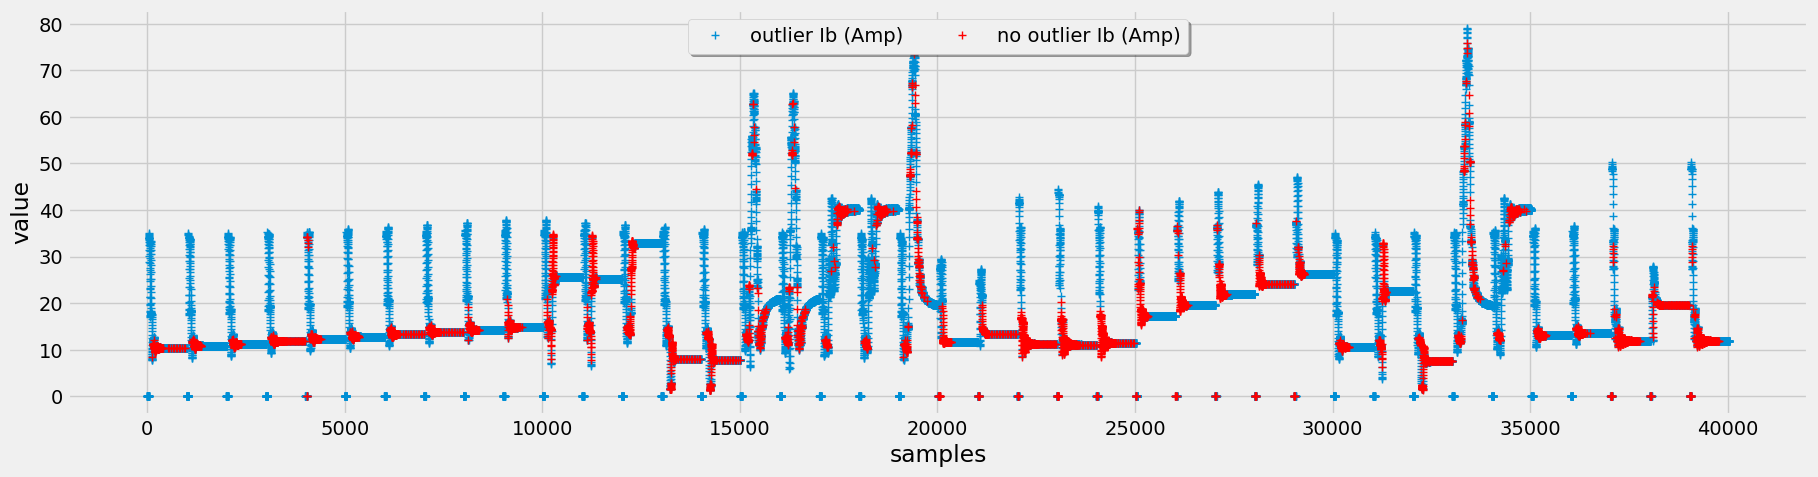

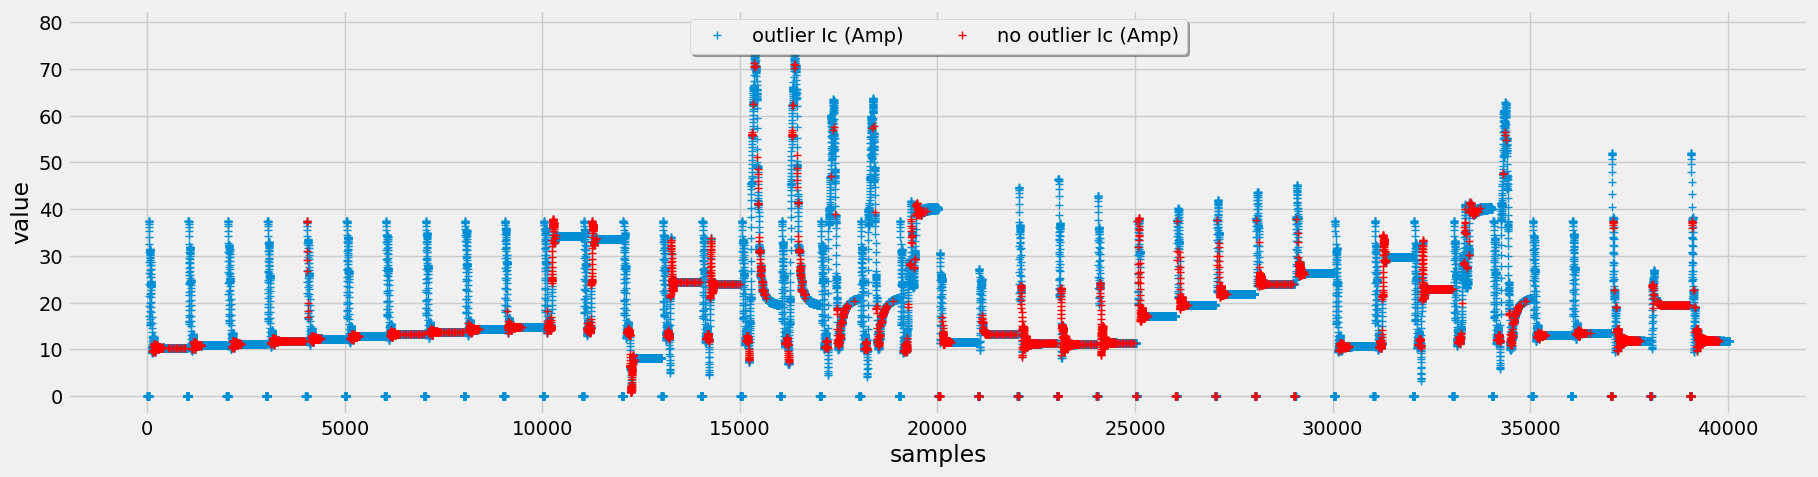

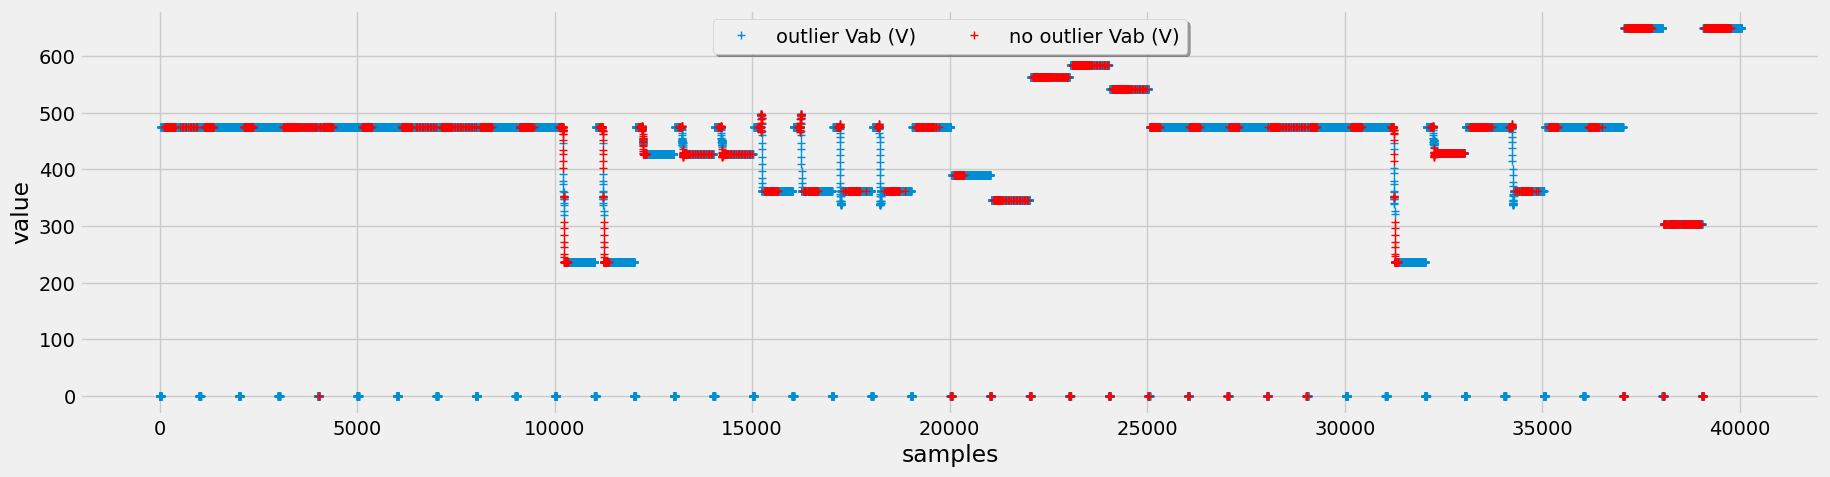

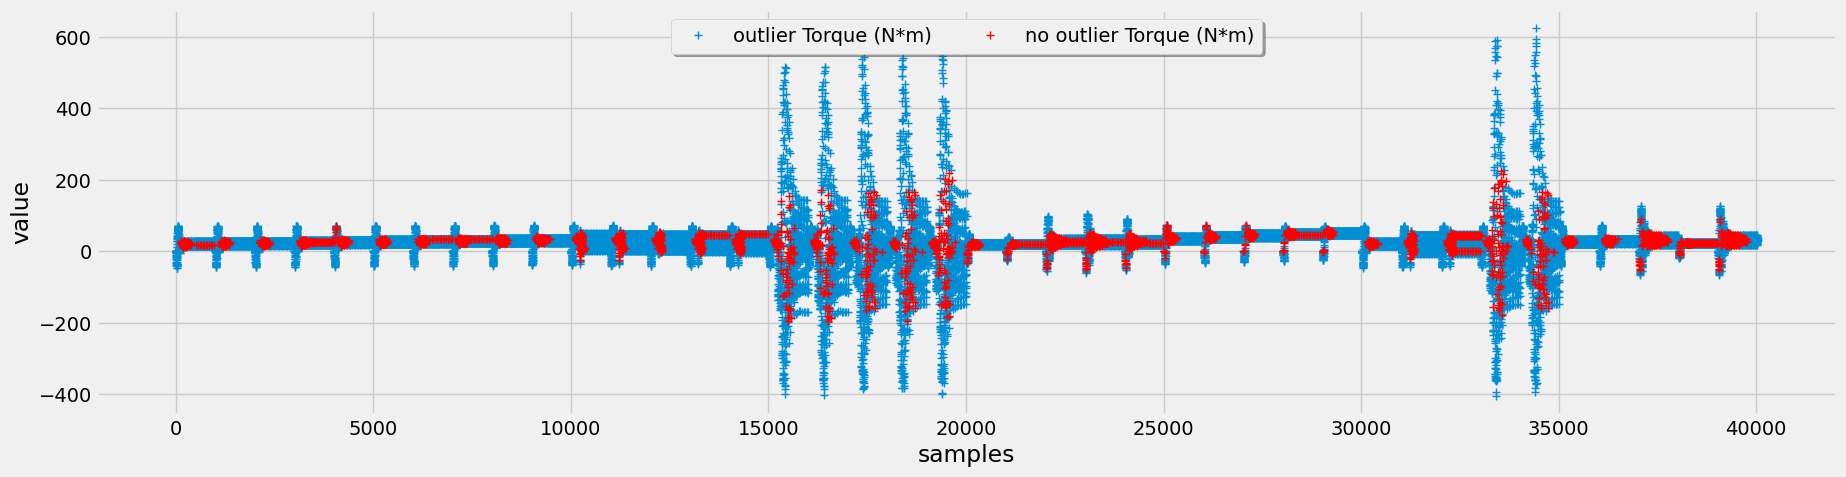

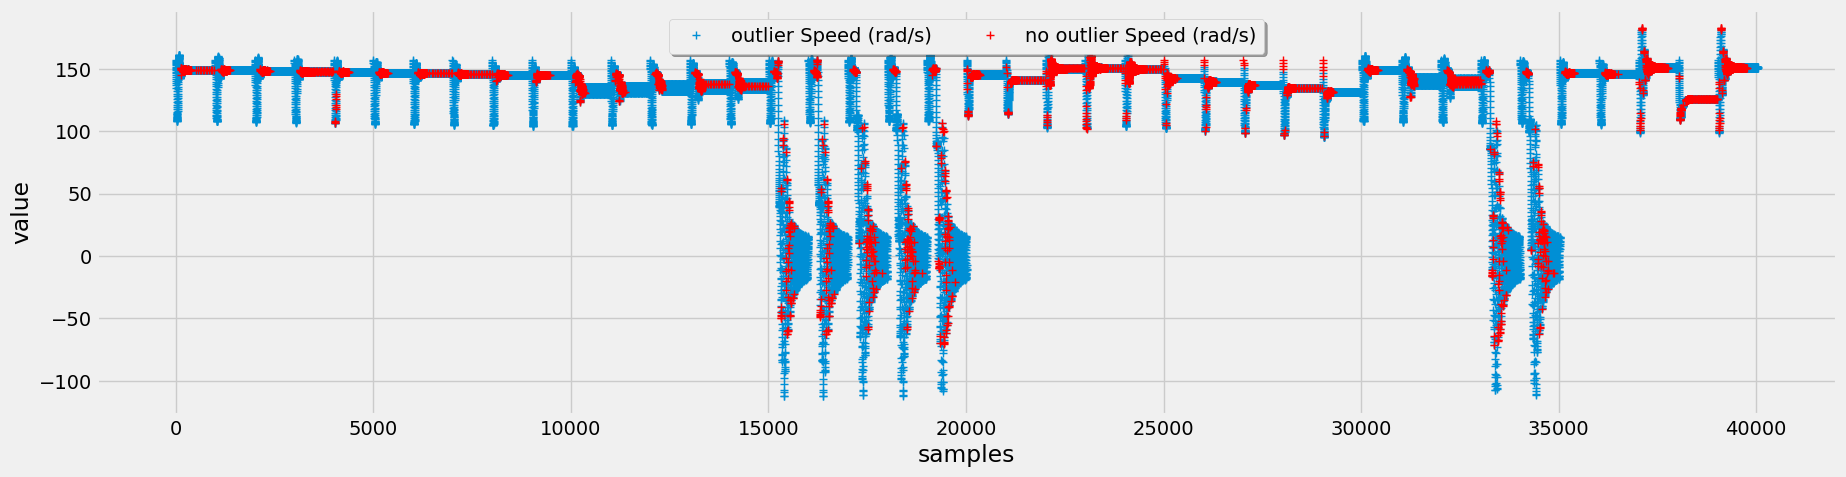

In [ ]:
for col in outlier_columns:
    plot_binary_outliers(dataset=dataset, col=col, outlier_col="outlier_lof",  reset_index=True)

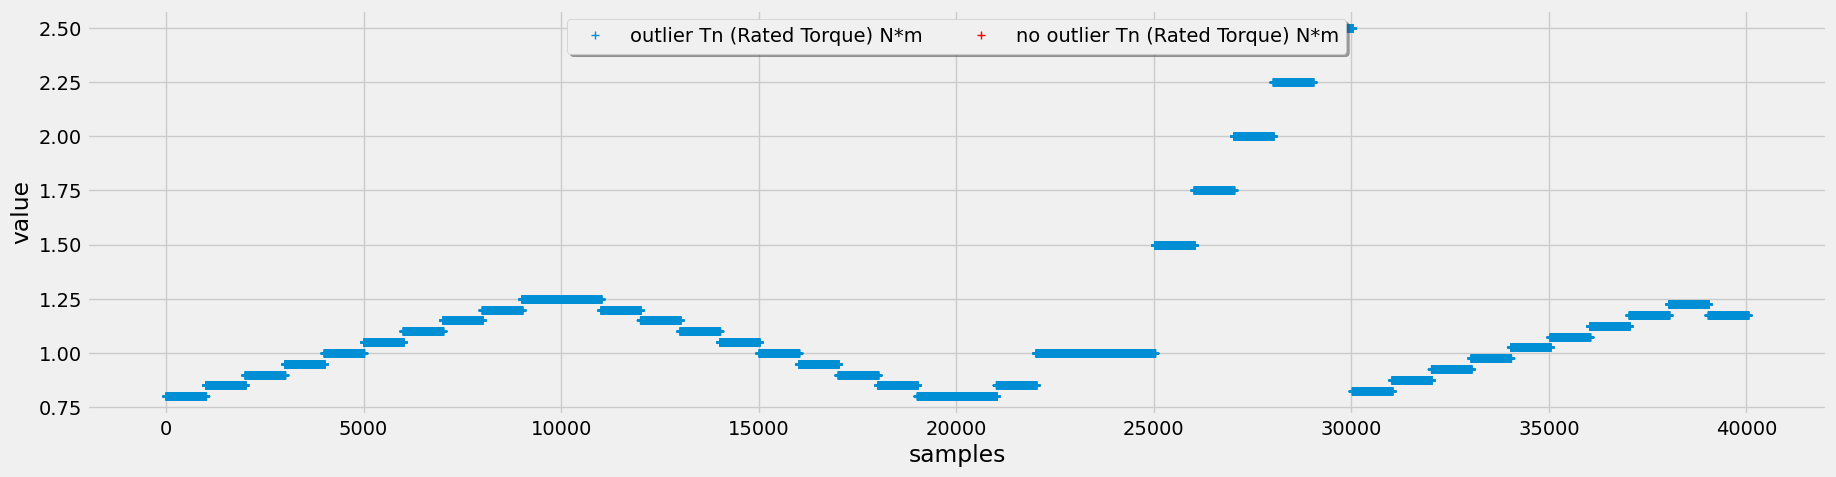

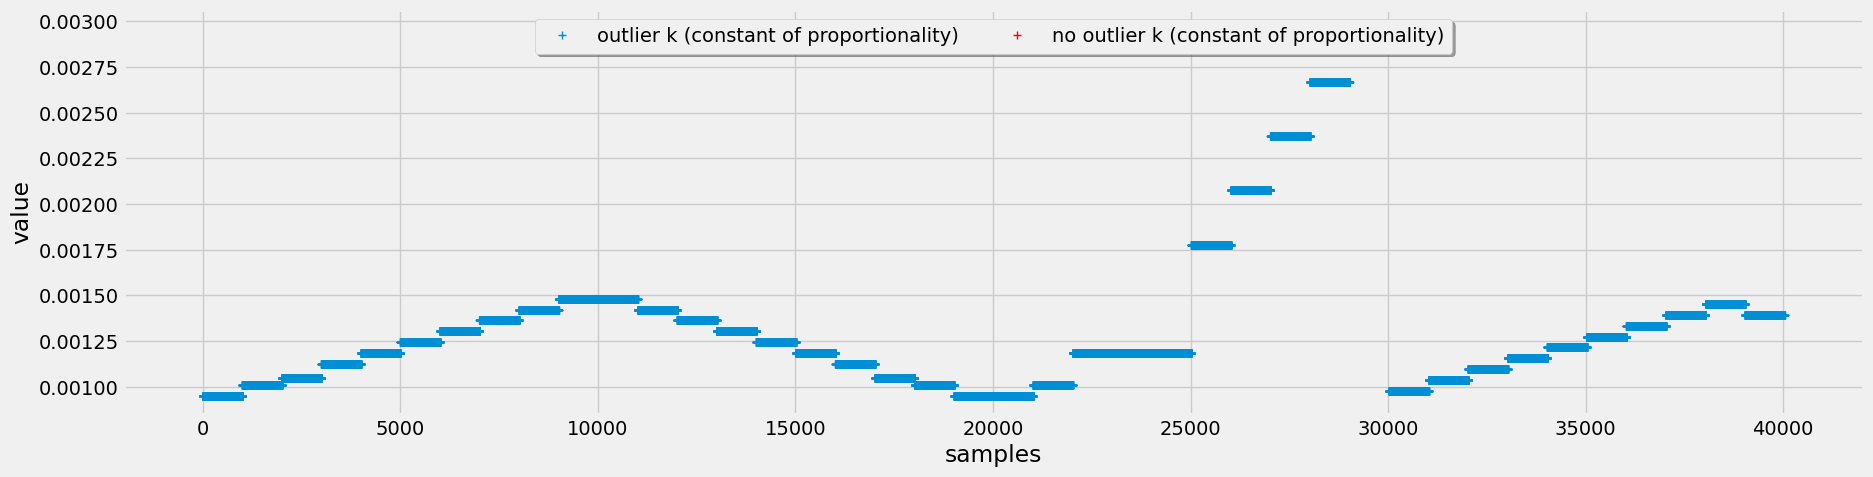

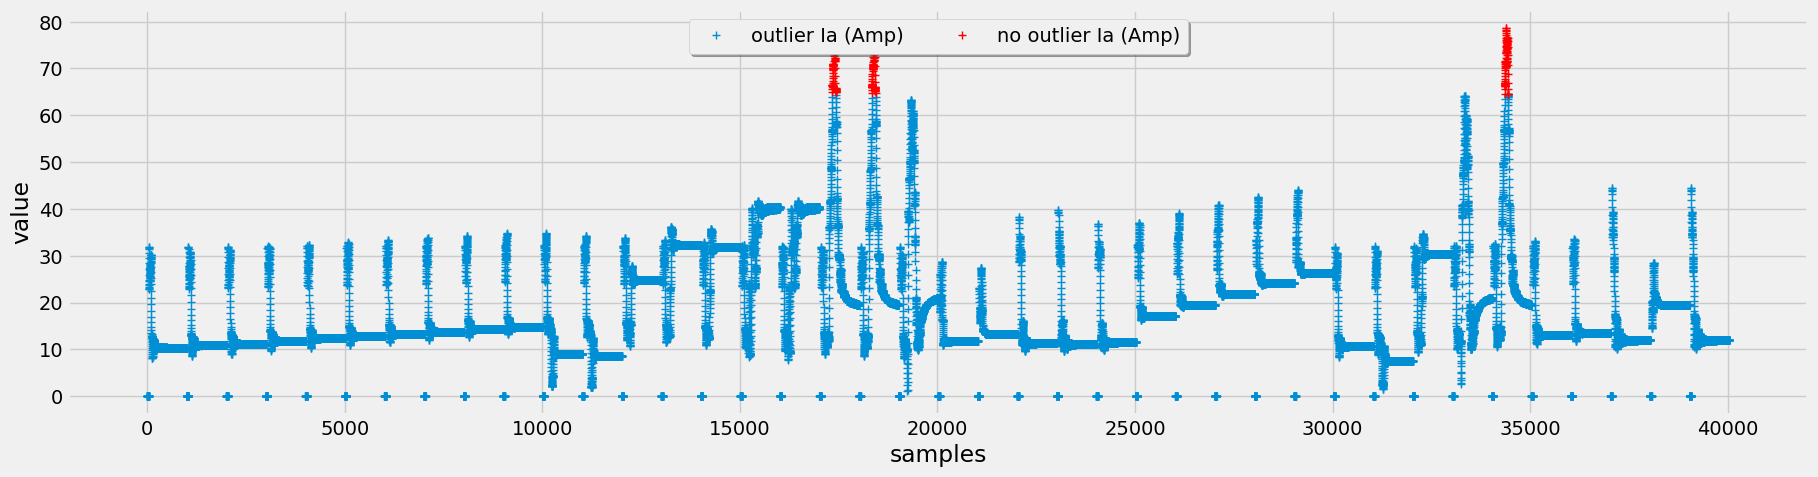

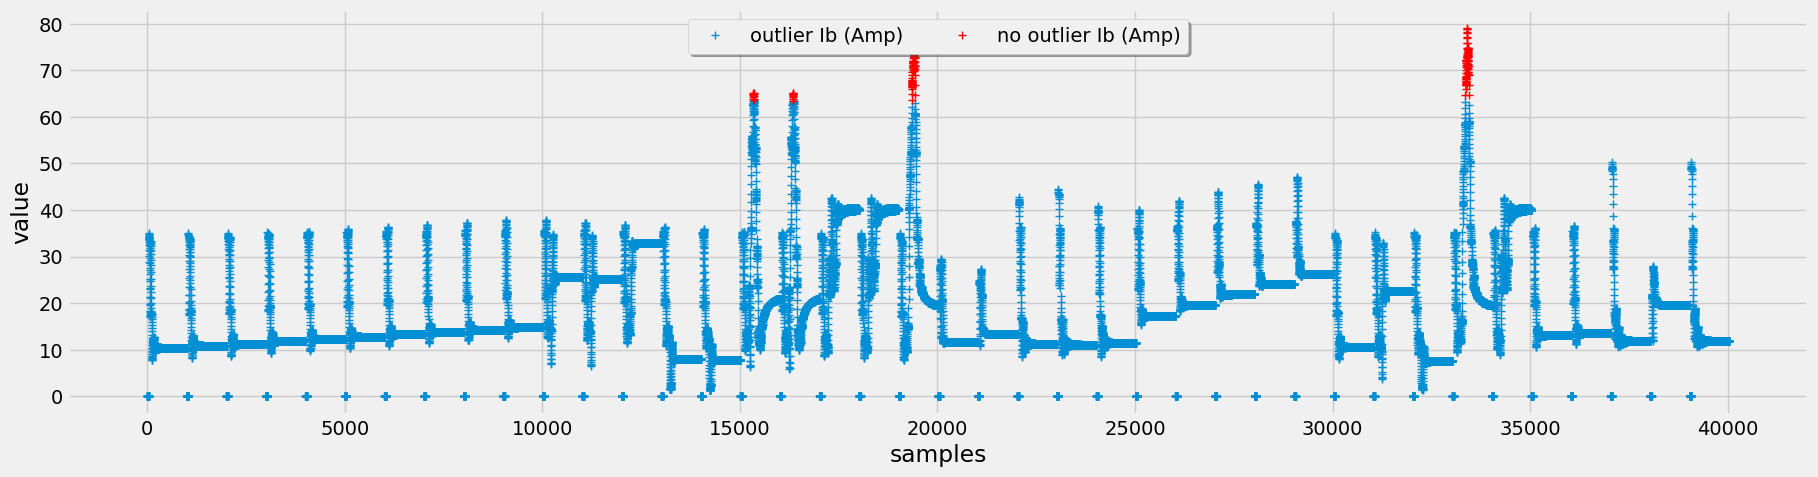

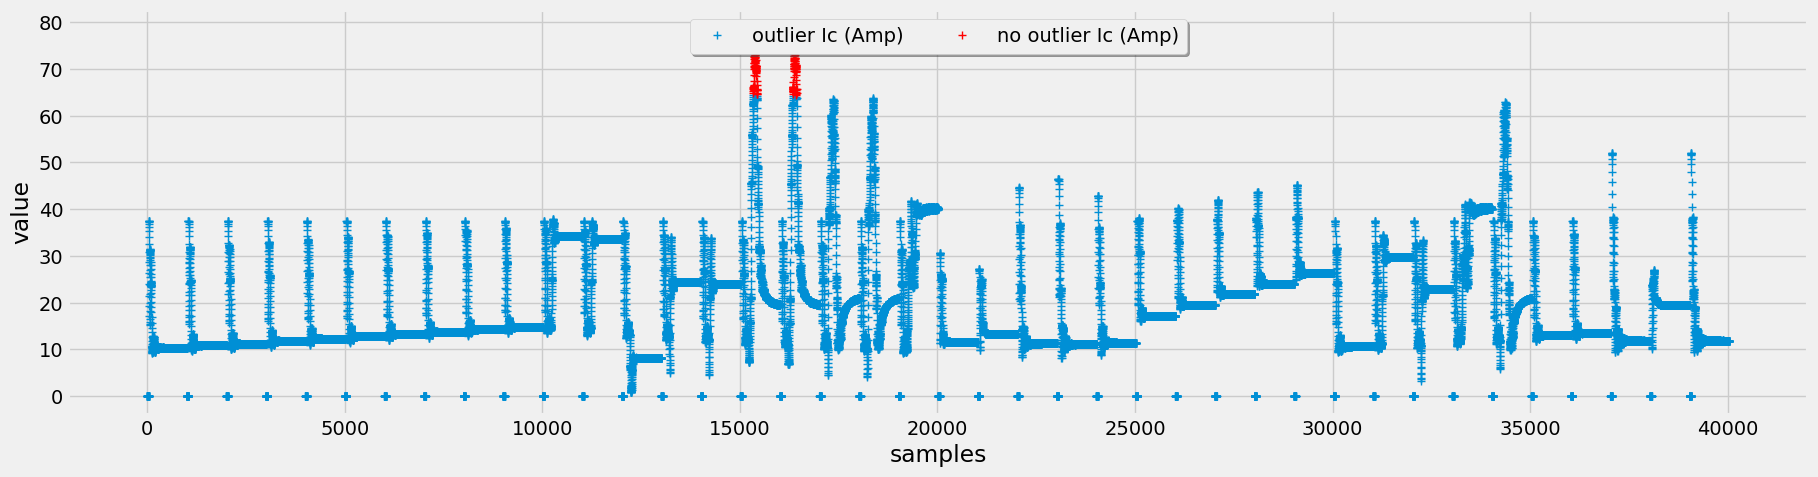

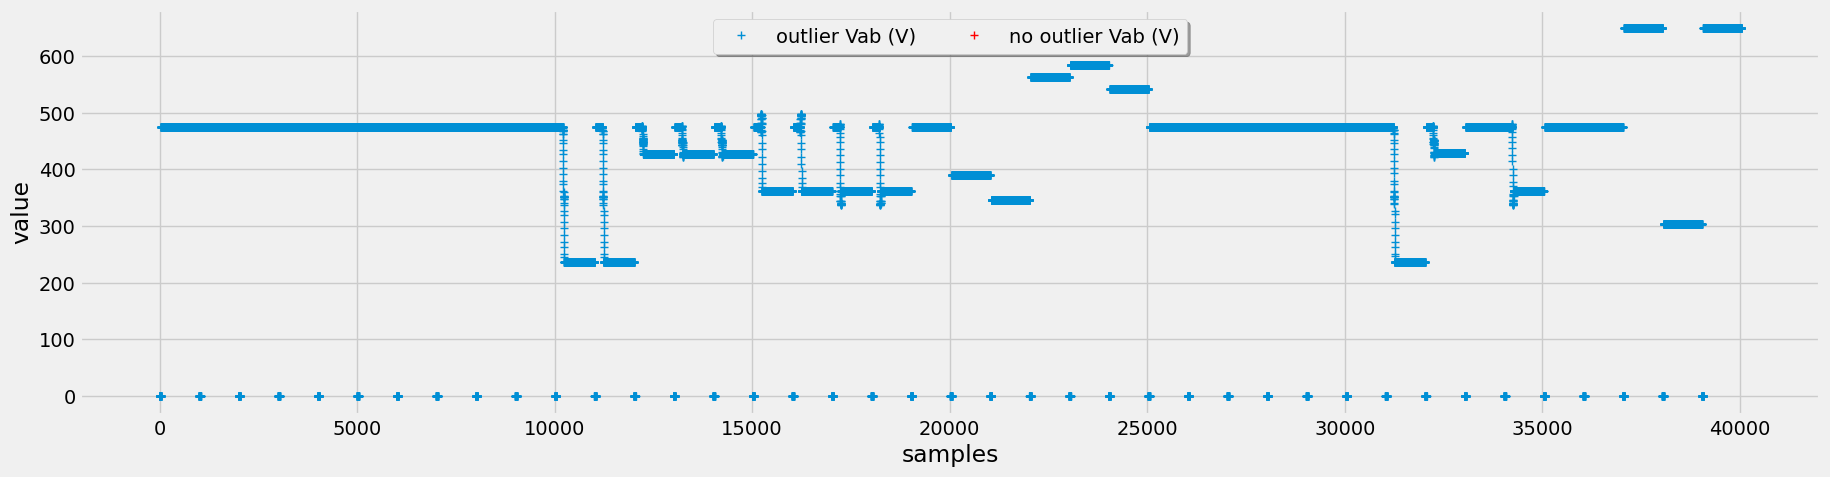

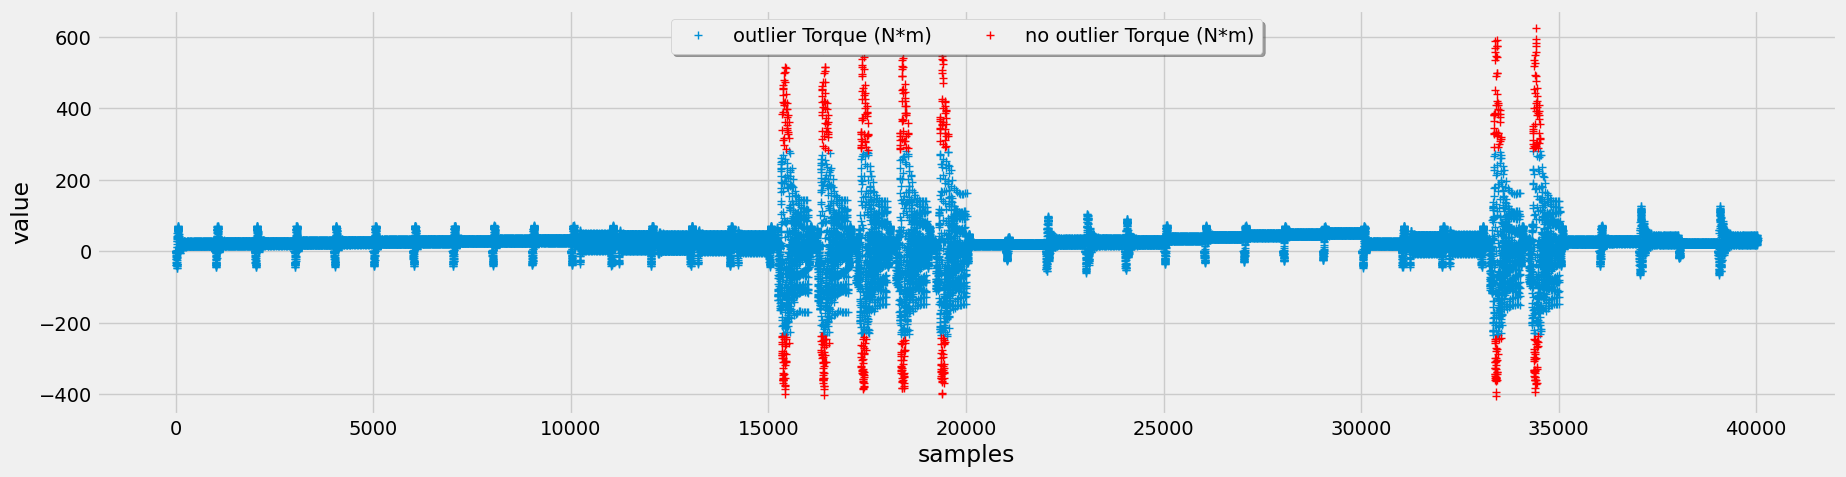

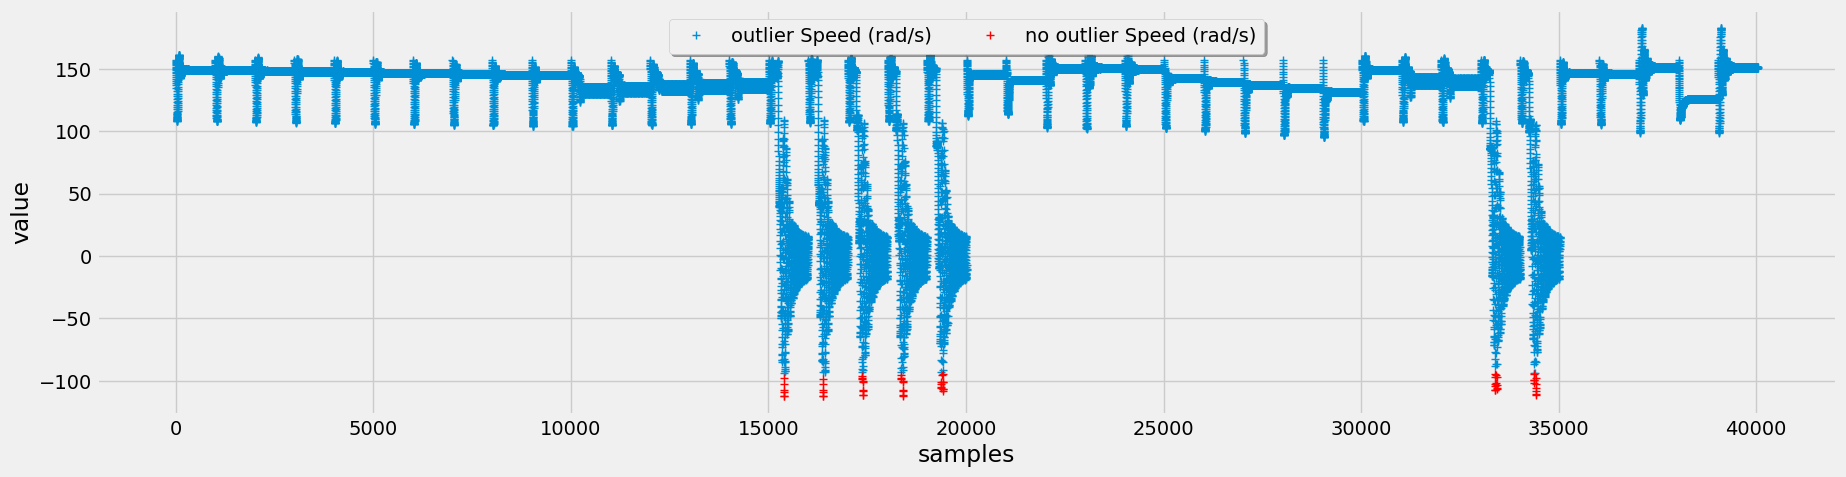

In [ ]:
#selectod method Chauvenets criteron

for col in outlier_columns:
    dataset = mark_outliers_chauvenet(df, col)
    plot_binary_outliers(dataset=dataset, col=col, outlier_col=col+"_outlier",  reset_index=True)